In [1]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce


In [2]:
L = 3 #system size
l=1 #spin length
M = 0.1
m_epsilon = 0
N=3
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [3]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2>           26  
      1.         |2 2 1>           25  
      2.         |2 2 0>           24  
      3.         |2 1 2>           23  
      4.         |2 1 1>           22  
      5.         |2 1 0>           21  
      6.         |2 0 2>           20  
      7.         |2 0 1>           19  
      8.         |2 0 0>           18  
      9.         |1 2 2>           17  
     10.         |1 2 1>           16  
     11.         |1 2 0>           15  
     12.         |1 1 2>           14  
     13.         |1 1 1>           13  
     14.         |1 1 0>           12  
     15.         |1 0 2>           11  
     16.         |1 0 1>           10  
     17.         |1 0 0>            9  
     18.         |0 2 2>            8  
     19.         |0 2 1>            7  
     20.         |0 2 0>            6  
     21.         |0 1 2>            5  
     22.         |0 1 1>            4  
     23.   

In [4]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [5]:
B = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(int(4*l)+1)
b[int(2*l)+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.        ]
[0. 0. 0. 1. 0.]


In [6]:
C = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(int(4*l)+1)
c[int(2*l)] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [7]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [8]:
A = np.zeros((int(2*l)+1,int(2*l)+1), dtype = complex)
for i in range(int(2*l)+1):
    for j in range(int(2*l)+1):
        A[i][j] = (-l+i)**j
b = np.zeros(int(2*l)+1,dtype = complex)
for i in range(int(2*l)+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(int(2*3/2)+1, dtype = complex)
for i in range(int(2*l)+1):
    x[i] = solution[i]
print(x)
print(x.conj())

[ 1.+0.j  0.+0.j -2.-0.j  0.+0.j]
[ 1.-0.j  0.-0.j -2.+0.j  0.-0.j]


In [9]:
D = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(int(4*l)+1)
d[int(2*l)] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [10]:
E = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(int(4*l)+1)
e[int(2*l)-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.        ]
[0. 1. 0. 0. 0.]


In [11]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [12]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []

const_term_conj = []
linear_term_conj = []
quadratic_term_conj = []
cubic_term_conj = []

interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])

    const_term_conj.append([[x.conj()[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term_conj.append([[x.conj()[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term_conj.append([[x.conj()[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term_conj.append([[x.conj()[3]/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])


    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],


    ])

    interaction_m.append([
        ["-", const_term_conj[i]],
        ["-z", linear_term_conj[i]],
        ["-zz", quadratic_term_conj[i]],
        ["-zzz", cubic_term_conj[i]],


    ])
    
const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])
const_term_conj.append([[(0.5*np.conj((-1)**m_epsilon))/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term_conj[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns),dtype = complex) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(L+1):
    full_ham_matrix = (Proj[i]+Proj_0[i])@full_ham_matrix@(Proj[i]+Proj_0[i])
full_ham_matrix = 1.*full_ham_matrix

G=0
for i in range(L+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= 1*(full_ham_matrix + constraint_full_matrix) #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [13]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])


[-0.64551385  0.42748942  0.7       ]


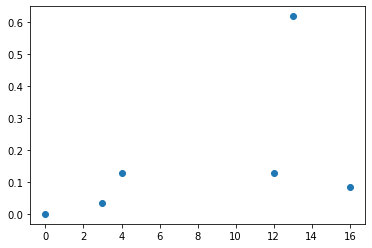

In [14]:
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])**2>=1e-4:
        y.append(np.abs(eigenvec[:,0][i])**2) 
        x.append(i)
plt.plot(x,y, "o")


In [15]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_r(i,j,phi,theta):
    sigma_r = sparse.identity(basis.Ns,dtype = complex)
    sigma_r = rot_sigma(0,i,j,phi,theta)@rot_sigma(L-1,i,j,phi,theta)
    return(sigma_r)


def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    for k in range(1,int(L/2)):
        sigma_e +=sigma(2*k,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    for k in range(int(L/2)):
        sigma_o +=sigma(2*k+1,i,j,phi)
    return sigma_o

def sigma_r(i,j,phi):
    sigma_r = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_r = sparse.csc_matrix(sigma_r)
    sigma_r = sigma(0,i,j,phi)+sigma(L-1,i,j,phi)
    return sigma_r

In [16]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

    
def ms_hamiltonian_1(i,j,phi):
    sigma_p = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_m = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_z = np.zeros((2*l+1,2*l+1),dtype = complex)
    
    sigma_p[2*l-j][2*l-i] = 1.
    sigma_m[2*l-i][2*l-j] = 1.
    
    sigma_z[2*l-i][2*l-i] = 1.
    sigma_z[2*l-j][2*l-j] = -1.
    
    sigma_p = sparse.csc_matrix(sigma_p)
    sigma_m = sparse.csc_matrix(sigma_m)
    sigma_z = sparse.csc_matrix(sigma_z)

    sigma_big_p = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_m = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_z = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]

    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    
    for k in range(L):
        if k == 0:
            tensprod_p = sigma_p
            tensprod_m = sigma_m
            tensprod_z = sigma_z

            for m in range(L-1):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()
            tensprod_z = tensprod_z.toarray()
        else:
            tensprod_p = sparse.identity(2*l+1)
            tensprod_m = sparse.identity(2*l+1)
            tensprod_z = sparse.identity(2*l+1)
            
            for i in range(1,k):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = scipy.sparse.kron(tensprod_p,sigma_p)
            tensprod_m = scipy.sparse.kron(tensprod_m,sigma_m)
            tensprod_z = scipy.sparse.kron(tensprod_z,sigma_z)            
            for i in range(k+1,L):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()    
            tensprod_z = tensprod_z.toarray() 
            
        sigma_big_p[k] = tensprod_p
        sigma_big_m[k] = tensprod_m
        sigma_big_z[k] = tensprod_z

    for k in range(L):
        summe += 1.*sigma_big_z[k]
        for kk in range(k+1,L):
            summe += 1./np.abs(k-kk)**2*(sigma_big_p[k]@sigma_big_m[kk] + sigma_big_m[k]@sigma_big_p[kk])
    return summe
                
matrix_part_1 = ms_hamiltonian_1(1,2,0)
ms_ham_eigenval_1, ms_ham_eigenvec_1 = scipy.linalg.eigh(matrix_part_1)




def ms_gate_global_1(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_1[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_1@exponential@ms_ham_eigenvec_1.T.conj()

In [42]:
def swap(m,n):
    swap_matrix = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    swap_matrix = sparse.csc_matrix(swap_matrix)
    for i in range(basis.Ns):
        state_m = basis.int_to_state(basis.Ns-i-1)[2*m+1]
        state_n = basis.int_to_state(basis.Ns-i-1)[2*n+1]
        string = list(basis.int_to_state(basis.Ns-i-1))
        string[2*m+1],string[2*n+1] = state_n,state_m
        string = "".join(string)
        string = string.replace(" ", "")
        string = string.replace("|","")
        string = string.replace(">", "")
        i_new = basis.Ns-1-basis.state_to_int(string)
        swap_matrix[i_new,i] = 1.
        
    return swap_matrix


def exp_gate(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = np.cos(theta/2)
    Matrix[8-1,8-1] = np.cos(theta/2)
    Matrix[8-2,8-2] = 0

    Matrix[8-3,8-3] = np.cos(theta/2)
    Matrix[8-4,8-4] = np.cos(theta/2)
    Matrix[8-5,8-5] = 0

    Matrix[8-6,8-6] = -np.cos(theta/2)
    Matrix[8-7,8-7] = np.cos(theta/2)
    Matrix[8-8,8-8] = -1j

    Matrix[8-0,8-4] = -1j*np.sin(theta/2)
    Matrix[8-4,8-0] = -1j*np.sin(theta/2)

    Matrix[8-1,8-3] = -1j*np.sin(theta/2)
    Matrix[8-3,8-1] = -1j*np.sin(theta/2)


    Matrix[8-5,8-2] = -1
    Matrix[8-2,8-5] = -1

    Matrix[8-6,8-7] = np.sin(theta/2)
    Matrix[8-7,8-6] = np.sin(theta/2)

    if k == 0:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3**(L-2)))
    
    else:
        Matrix_full = scipy.sparse.kron(sparse.identity(3**k),Matrix)
        Matrix_full = scipy.sparse.kron(Matrix_full,sparse.identity(3**((L-2)-k)))

    #return swap(0,k)@swap(1,k+1)@Matrix_full@swap(0,k+1)@swap(1,k)
    return Matrix_full

In [50]:
def exp_gate_der(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = -np.sin(theta/2)/2
    Matrix[8-1,8-1] = -np.sin(theta/2)/2

    Matrix[8-3,8-3] = -np.sin(theta/2)/2
    Matrix[8-4,8-4] = -np.sin(theta/2)/2

    Matrix[8-6,8-6] = np.sin(theta/2)/2
    Matrix[8-7,8-7] = -np.sin(theta/2)/2

    Matrix[8-0,8-4] = -1j*np.cos(theta/2)/2
    Matrix[8-4,8-0] = -1j*np.cos(theta/2)/2

    Matrix[8-1,8-3] = -1j*np.cos(theta/2)/2
    Matrix[8-3,8-1] = -1j*np.cos(theta/2)/2



    Matrix[8-6,8-7] = np.cos(theta/2)/2
    Matrix[8-7,8-6] = np.cos(theta/2)/2
    
    if k == 0:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3**(L-2)))
    
    else:
        Matrix_full = scipy.sparse.kron(sparse.identity(3**k),Matrix)
        Matrix_full = scipy.sparse.kron(Matrix_full,sparse.identity(3**((L-2)-k)))

    #return swap(0,k)@swap(1,k+1)@Matrix_full@swap(0,k+1)@swap(1,k)
    return Matrix_full




In [51]:
%time exp_gate_der(0,np.pi/3)

CPU times: user 1.53 ms, sys: 4.01 ms, total: 5.55 ms
Wall time: 4.8 ms


<27x27 sparse matrix of type '<class 'numpy.complex128'>'
	with 36 stored elements in COOrdinate format>

In [52]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [97]:
def R(i,theta):
    
    if i%8 == 0:
        return(exp_gate(0,theta))

    if i%8 == 1:
        return(exp_gate(1,theta))

    if i%8 == 2:
        return(rot_sigma_o(0,1,0,theta))


    if i%8 == 3:
        return(rot_sigma_o(0,2,0,theta))

    
    if i%8 == 4:
        return(rot_sigma_o(1,2,np.pi/2,theta))

    
    if i%8 == 5:
        return(rot_sigma_r(0,1,0,theta))


    if i%8 == 6:
        return(rot_sigma_r(0,2,0,theta))

    
    if i%8 == 7:
        return(rot_sigma_r(1,2,np.pi/2,theta))

        

def S(i,theta):
    
    if i%8 == 0:
        return(exp_gate_der(0,theta)@exp_gate(0,theta).T.conj())

    if i%8 == 1:
        return(exp_gate_der(1,theta)@exp_gate(1,theta).T.conj())
    
     
    if i%8 == 2:
        return(-1j*sigma_o(0,1,0))

    
    if i%8 == 3:
        return(-1j*sigma_o(0,2,0))

    
    if i%8 == 4:
        return(-1j*sigma_o(1,2,np.pi/2))

     
    if i%8 == 5:
        return(-1j*sigma_r(0,1,0))

    
    if i%8 == 6:
        return(-1j*sigma_r(0,2,0))
    

    if i%8 == 7:
        return(-1j*sigma_r(1,2,np.pi/2))

In [98]:
coeff = 8
stepp = 500
t_final = 10

In [99]:
expt_value = []
energyy = []

time_domain = np.linspace(0, t_final, stepp)

Y = []
THETA_1 = []
THETA_2 = []
THETA_3 = []

In [100]:
for i in range(100):
    if i%50 == 0:
        print(i)

0
50


In [101]:
for kkk in range(3):
    counter = 0
    N=kkk+1
    start_point = np.random.rand(coeff*N)

    matr = full_ham_matrix.toarray()
    B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
    psi_d = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_1 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_s1 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_s2 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]

    def rhs(t,theta):

        print(datetime.datetime.now())
        for k in range(coeff*N):
            B[k] = R(k,theta[k])

        psi_b = psi_0
        for k in range(coeff*N):
            psi_b = B[coeff*N-1-k]@psi_b
        for i in range(L+1):
            psi_b = (Proj[i]+Proj_0[i])@psi_b
        norm_b = np.sqrt(np.real(np.conj(psi_b)@psi_b))
        psi_b = psi_b/norm_b



        psi_conj_b = np.conj(psi_b)

        print("start",datetime.datetime.now())

        for k in range(coeff*N):
            B[k] = S(k,theta[k])@R(k,theta[k])
            psi_d[k] = psi_0
            for i in range(coeff*N):
                psi_d[k] = B[coeff*N-1-i]@psi_d[k]
            B[k] = R(k,theta[k])

        print("stop_reduce",datetime.datetime.now())

        psi_conj_d = np.conj(psi_d)


        for k in range(coeff*N):
            for i in range(L+1):
                psi_d_1[k] = (Proj[i]+Proj_0[i])@psi_d[k]  
            psi_d_s1[k] = psi_d_1[k]/norm_b
            psi_d_s2[k] = -psi_b*(psi_conj_d[k]@psi_b+psi_conj_b@psi_d[k])
            psi_d[k] = psi_d_s1[k]+psi_d_s2[k]

        psi_conj_d = np.conj(psi_d)




        X = np.zeros((coeff*N,coeff*N),dtype = complex)
        Y = np.zeros(coeff*N,dtype = complex)


        X = np.einsum("in,jn->ij",psi_conj_d,psi_d)

        Y = np.einsum("il,ln,n->i",psi_conj_d,matr,psi_b)

        XX = np.einsum("il,l->i",psi_conj_d,psi_b)

        YY_1 = np.einsum("n,in->i",psi_conj_b,psi_d)

        YY_2 = np.einsum("i,ij,j",psi_conj_b,matr,psi_b)
        YY = YY_1*YY_2
        XX = np.outer(XX,XX)
        X_r = 2*np.real(X+XX)
        Y_i = 2*np.real(Y+YY)
        result = -np.linalg.pinv(X_r,rcond = 1e-6)@Y_i
        print(datetime.datetime.now())

        print(t)

        return result

    # RK-4 method
    def rk4(x0,y0,xn,n):
        global Y
        global THETA
        global N
        global counter

        # Calculating step size
        h = (xn-x0)/n

        #print('\n--------SOLUTION--------')
        #print('-------------------------')    
        #print('x0\ty0\tyn')
        #print('-------------------------')
        for i in range(n):
            k1 = h * (rhs(x0, y0))
            k2 = h * (rhs((x0+h/2), (y0+k1/2)))
            k3 = h * (rhs((x0+h/2), (y0+k2/2)))
            k4 = h * (rhs((x0+h), (y0+k3)))
            k = (k1+2*k2+2*k3+k4)/6
            yn = y0 + k
            #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
            #print('-------------------------')
            y0 = yn
            x0 = x0+h
            Y.append(y0)
            if (counter%50 == 1) & (N == 1):
                THETA_1.append(y0)
            if (counter%50 == 1) & (N == 2):
                THETA_2.append(y0)
            if (counter%50 == 1) & (N == 3):
                THETA_3.append(y0)
            counter +=1

        #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

    # Inputs
    #print('Enter initial conditions:')
    #x0 = float(input('x0 = '))
    #y0 = float(input('y0 = '))

    #print('Enter calculation point: ')
    #xn = float(input('xn = '))

    #print('Enter number of steps:')
    #step = int(input('Number of steps = '))

    # RK4 method call
    #start_point = 0.001*np.ones(coeff*N)




    Y = []
    #start_point = np.zeros(coeff*N)

    rk4(0,start_point,t_final,stepp)
    def var_ansatz(theta,psi_0):
        psi = psi_0
        for i in range(coeff*N):
            psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

        return psi
    psi = var_ansatz(start_point,psi_0)
    psi_ground = eigenvec[:,0]
    expt_value_u = np.zeros(len(time_domain))
    energy = np.zeros(len(time_domain))

    psi = var_ansatz(start_point,psi_0)
    for tt in range(len(time_domain)):
        theta = []
        for i in range(coeff*N):
            theta.append(Y[tt][i])


        psi_var = var_ansatz(theta,psi_0)
        for i in range(L+1):
            psi_var = (Proj[i]+Proj_0[i])@psi_var
        norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))

        expt_value_u[tt] = np.abs(np.conj(psi_var)@psi_ground/norm)**2
        energy[tt] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2)
        
    expt_value.append(expt_value_u)
    energyy.append(energy)


    

2022-08-18 14:38:08.587292
start 2022-08-18 14:38:08.622477
stop_reduce 2022-08-18 14:38:08.694851
2022-08-18 14:38:08.698600
0
2022-08-18 14:38:08.698637
start 2022-08-18 14:38:08.728362
stop_reduce 2022-08-18 14:38:08.803633
2022-08-18 14:38:08.807420
0.01
2022-08-18 14:38:08.807471
start 2022-08-18 14:38:08.837714
stop_reduce 2022-08-18 14:38:08.911627
2022-08-18 14:38:08.915354
0.01
2022-08-18 14:38:08.915390
start 2022-08-18 14:38:08.945262
stop_reduce 2022-08-18 14:38:09.020490
2022-08-18 14:38:09.024471
0.02
2022-08-18 14:38:09.024547
start 2022-08-18 14:38:09.055223
stop_reduce 2022-08-18 14:38:09.129574
2022-08-18 14:38:09.133389
0.02
2022-08-18 14:38:09.133528
start 2022-08-18 14:38:09.163534
stop_reduce 2022-08-18 14:38:09.240003
2022-08-18 14:38:09.243835
0.03
2022-08-18 14:38:09.243920
start 2022-08-18 14:38:09.274347
stop_reduce 2022-08-18 14:38:09.348932
2022-08-18 14:38:09.352703
0.03
2022-08-18 14:38:09.352747
start 2022-08-18 14:38:09.382812
stop_reduce 2022-08-18 14:

stop_reduce 2022-08-18 14:38:15.992119
2022-08-18 14:38:15.996682
0.3
2022-08-18 14:38:15.996747
start 2022-08-18 14:38:16.029414
stop_reduce 2022-08-18 14:38:16.108829
2022-08-18 14:38:16.112992
0.31
2022-08-18 14:38:16.113042
start 2022-08-18 14:38:16.150990
stop_reduce 2022-08-18 14:38:16.242224
2022-08-18 14:38:16.246654
0.31
2022-08-18 14:38:16.246748
start 2022-08-18 14:38:16.284596
stop_reduce 2022-08-18 14:38:16.368416
2022-08-18 14:38:16.372856
0.32
2022-08-18 14:38:16.372921
start 2022-08-18 14:38:16.407812
stop_reduce 2022-08-18 14:38:16.492779
2022-08-18 14:38:16.496729
0.32
2022-08-18 14:38:16.496775
start 2022-08-18 14:38:16.529039
stop_reduce 2022-08-18 14:38:16.607548
2022-08-18 14:38:16.611366
0.33
2022-08-18 14:38:16.611418
start 2022-08-18 14:38:16.640622
stop_reduce 2022-08-18 14:38:16.719961
2022-08-18 14:38:16.724307
0.33
2022-08-18 14:38:16.724354
start 2022-08-18 14:38:16.753375
stop_reduce 2022-08-18 14:38:16.831325
2022-08-18 14:38:16.835446
0.34
2022-08-18 14

stop_reduce 2022-08-18 14:38:22.400261
2022-08-18 14:38:22.403983
0.5900000000000002
2022-08-18 14:38:22.404018
start 2022-08-18 14:38:22.435238
stop_reduce 2022-08-18 14:38:22.510268
2022-08-18 14:38:22.514009
0.6000000000000002
2022-08-18 14:38:22.514055
start 2022-08-18 14:38:22.544165
stop_reduce 2022-08-18 14:38:22.626087
2022-08-18 14:38:22.629900
0.6000000000000002
2022-08-18 14:38:22.629939
start 2022-08-18 14:38:22.660181
stop_reduce 2022-08-18 14:38:22.734725
2022-08-18 14:38:22.738420
0.6100000000000002
2022-08-18 14:38:22.738457
start 2022-08-18 14:38:22.768730
stop_reduce 2022-08-18 14:38:22.843684
2022-08-18 14:38:22.847425
0.6100000000000002
2022-08-18 14:38:22.847457
start 2022-08-18 14:38:22.877605
stop_reduce 2022-08-18 14:38:22.952131
2022-08-18 14:38:22.955901
0.6200000000000002
2022-08-18 14:38:22.955940
start 2022-08-18 14:38:22.986412
stop_reduce 2022-08-18 14:38:23.061768
2022-08-18 14:38:23.065497
0.6200000000000002
2022-08-18 14:38:23.065535
start 2022-08-18 1

stop_reduce 2022-08-18 14:38:28.797556
2022-08-18 14:38:28.801319
0.8800000000000004
2022-08-18 14:38:28.801353
start 2022-08-18 14:38:28.831547
stop_reduce 2022-08-18 14:38:28.906224
2022-08-18 14:38:28.909917
0.8900000000000005
2022-08-18 14:38:28.909955
start 2022-08-18 14:38:28.940133
stop_reduce 2022-08-18 14:38:29.015070
2022-08-18 14:38:29.018822
0.8900000000000005
2022-08-18 14:38:29.018858
start 2022-08-18 14:38:29.049081
stop_reduce 2022-08-18 14:38:29.123497
2022-08-18 14:38:29.127195
0.9000000000000005
2022-08-18 14:38:29.127233
start 2022-08-18 14:38:29.157463
stop_reduce 2022-08-18 14:38:29.232539
2022-08-18 14:38:29.236252
0.9000000000000005
2022-08-18 14:38:29.236289
start 2022-08-18 14:38:29.266396
stop_reduce 2022-08-18 14:38:29.341025
2022-08-18 14:38:29.344687
0.9100000000000005
2022-08-18 14:38:29.344725
start 2022-08-18 14:38:29.374865
stop_reduce 2022-08-18 14:38:29.450661
2022-08-18 14:38:29.454453
0.9100000000000005
2022-08-18 14:38:29.454490
start 2022-08-18 1

stop_reduce 2022-08-18 14:38:35.216562
2022-08-18 14:38:35.221253
1.1700000000000006
2022-08-18 14:38:35.221292
start 2022-08-18 14:38:35.267289
stop_reduce 2022-08-18 14:38:35.353804
2022-08-18 14:38:35.357759
1.1800000000000006
2022-08-18 14:38:35.357814
start 2022-08-18 14:38:35.388099
stop_reduce 2022-08-18 14:38:35.468636
2022-08-18 14:38:35.473627
1.1800000000000006
2022-08-18 14:38:35.473673
start 2022-08-18 14:38:35.509323
stop_reduce 2022-08-18 14:38:35.605564
2022-08-18 14:38:35.610352
1.1900000000000006
2022-08-18 14:38:35.610411
start 2022-08-18 14:38:35.651241
stop_reduce 2022-08-18 14:38:35.752502
2022-08-18 14:38:35.757980
1.1900000000000006
2022-08-18 14:38:35.758044
start 2022-08-18 14:38:35.795939
stop_reduce 2022-08-18 14:38:35.885372
2022-08-18 14:38:35.890148
1.2000000000000006
2022-08-18 14:38:35.890335
start 2022-08-18 14:38:35.926556
stop_reduce 2022-08-18 14:38:36.018430
2022-08-18 14:38:36.022605
1.2000000000000006
2022-08-18 14:38:36.022670
start 2022-08-18 1

stop_reduce 2022-08-18 14:38:41.628728
2022-08-18 14:38:41.632552
1.4600000000000009
2022-08-18 14:38:41.632591
start 2022-08-18 14:38:41.662781
stop_reduce 2022-08-18 14:38:41.737454
2022-08-18 14:38:41.741190
1.4700000000000009
2022-08-18 14:38:41.741228
start 2022-08-18 14:38:41.771613
stop_reduce 2022-08-18 14:38:41.850626
2022-08-18 14:38:41.854420
1.4700000000000009
2022-08-18 14:38:41.854452
start 2022-08-18 14:38:41.884676
stop_reduce 2022-08-18 14:38:41.959397
2022-08-18 14:38:41.963458
1.4800000000000009
2022-08-18 14:38:41.963512
start 2022-08-18 14:38:41.994750
stop_reduce 2022-08-18 14:38:42.070417
2022-08-18 14:38:42.074219
1.4800000000000009
2022-08-18 14:38:42.074255
start 2022-08-18 14:38:42.104562
stop_reduce 2022-08-18 14:38:42.179308
2022-08-18 14:38:42.183026
1.4900000000000009
2022-08-18 14:38:42.183064
start 2022-08-18 14:38:42.213343
stop_reduce 2022-08-18 14:38:42.288878
2022-08-18 14:38:42.292659
1.4900000000000009
2022-08-18 14:38:42.292691
start 2022-08-18 1

stop_reduce 2022-08-18 14:38:47.952606
2022-08-18 14:38:47.956472
1.750000000000001
2022-08-18 14:38:47.956512
start 2022-08-18 14:38:47.987212
stop_reduce 2022-08-18 14:38:48.062414
2022-08-18 14:38:48.066249
1.7600000000000011
2022-08-18 14:38:48.066295
start 2022-08-18 14:38:48.096700
stop_reduce 2022-08-18 14:38:48.172514
2022-08-18 14:38:48.176366
1.7600000000000011
2022-08-18 14:38:48.176400
start 2022-08-18 14:38:48.206890
stop_reduce 2022-08-18 14:38:48.281970
2022-08-18 14:38:48.285727
1.7700000000000011
2022-08-18 14:38:48.285766
start 2022-08-18 14:38:48.315900
stop_reduce 2022-08-18 14:38:48.391217
2022-08-18 14:38:48.394995
1.7700000000000011
2022-08-18 14:38:48.395032
start 2022-08-18 14:38:48.425643
stop_reduce 2022-08-18 14:38:48.501082
2022-08-18 14:38:48.505001
1.7800000000000011
2022-08-18 14:38:48.505051
start 2022-08-18 14:38:48.535492
stop_reduce 2022-08-18 14:38:48.611192
2022-08-18 14:38:48.614987
1.7800000000000011
2022-08-18 14:38:48.615029
start 2022-08-18 14

stop_reduce 2022-08-18 14:38:54.366359
2022-08-18 14:38:54.370167
2.0400000000000014
2022-08-18 14:38:54.370207
start 2022-08-18 14:38:54.400449
stop_reduce 2022-08-18 14:38:54.475276
2022-08-18 14:38:54.479022
2.050000000000001
2022-08-18 14:38:54.479061
start 2022-08-18 14:38:54.509776
stop_reduce 2022-08-18 14:38:54.585256
2022-08-18 14:38:54.589112
2.050000000000001
2022-08-18 14:38:54.589150
start 2022-08-18 14:38:54.619411
stop_reduce 2022-08-18 14:38:54.695247
2022-08-18 14:38:54.698934
2.0600000000000014
2022-08-18 14:38:54.698978
start 2022-08-18 14:38:54.729194
stop_reduce 2022-08-18 14:38:54.804703
2022-08-18 14:38:54.808465
2.0600000000000014
2022-08-18 14:38:54.808503
start 2022-08-18 14:38:54.838943
stop_reduce 2022-08-18 14:38:54.913768
2022-08-18 14:38:54.917473
2.070000000000001
2022-08-18 14:38:54.917506
start 2022-08-18 14:38:54.947643
stop_reduce 2022-08-18 14:38:55.030970
2022-08-18 14:38:55.034887
2.070000000000001
2022-08-18 14:38:55.034927
start 2022-08-18 14:38

stop_reduce 2022-08-18 14:39:00.791153
2022-08-18 14:39:00.794965
2.3300000000000014
2022-08-18 14:39:00.795040
start 2022-08-18 14:39:00.825307
stop_reduce 2022-08-18 14:39:00.899921
2022-08-18 14:39:00.903634
2.3400000000000016
2022-08-18 14:39:00.903677
start 2022-08-18 14:39:00.934136
stop_reduce 2022-08-18 14:39:01.010591
2022-08-18 14:39:01.014547
2.3400000000000016
2022-08-18 14:39:01.014594
start 2022-08-18 14:39:01.050787
stop_reduce 2022-08-18 14:39:01.126550
2022-08-18 14:39:01.130268
2.3500000000000014
2022-08-18 14:39:01.130308
start 2022-08-18 14:39:01.161021
stop_reduce 2022-08-18 14:39:01.236696
2022-08-18 14:39:01.240566
2.3500000000000014
2022-08-18 14:39:01.240620
start 2022-08-18 14:39:01.271450
stop_reduce 2022-08-18 14:39:01.346328
2022-08-18 14:39:01.350075
2.3600000000000017
2022-08-18 14:39:01.350120
start 2022-08-18 14:39:01.380411
stop_reduce 2022-08-18 14:39:01.456028
2022-08-18 14:39:01.459857
2.3600000000000017
2022-08-18 14:39:01.459890
start 2022-08-18 1

stop_reduce 2022-08-18 14:39:07.171596
2022-08-18 14:39:07.175434
2.620000000000002
2022-08-18 14:39:07.175473
start 2022-08-18 14:39:07.205357
stop_reduce 2022-08-18 14:39:07.279357
2022-08-18 14:39:07.283072
2.6300000000000017
2022-08-18 14:39:07.283111
start 2022-08-18 14:39:07.312997
stop_reduce 2022-08-18 14:39:07.387468
2022-08-18 14:39:07.391282
2.6300000000000017
2022-08-18 14:39:07.391320
start 2022-08-18 14:39:07.421147
stop_reduce 2022-08-18 14:39:07.496741
2022-08-18 14:39:07.500455
2.640000000000002
2022-08-18 14:39:07.500493
start 2022-08-18 14:39:07.531681
stop_reduce 2022-08-18 14:39:07.606777
2022-08-18 14:39:07.610628
2.640000000000002
2022-08-18 14:39:07.610670
start 2022-08-18 14:39:07.641034
stop_reduce 2022-08-18 14:39:07.715112
2022-08-18 14:39:07.718848
2.6500000000000017
2022-08-18 14:39:07.718882
start 2022-08-18 14:39:07.748863
stop_reduce 2022-08-18 14:39:07.824558
2022-08-18 14:39:07.828359
2.6500000000000017
2022-08-18 14:39:07.828393
start 2022-08-18 14:3

stop_reduce 2022-08-18 14:39:13.503706
2022-08-18 14:39:13.507493
2.910000000000002
2022-08-18 14:39:13.507526
start 2022-08-18 14:39:13.537973
stop_reduce 2022-08-18 14:39:13.612395
2022-08-18 14:39:13.616205
2.920000000000002
2022-08-18 14:39:13.616254
start 2022-08-18 14:39:13.646153
stop_reduce 2022-08-18 14:39:13.720793
2022-08-18 14:39:13.724604
2.920000000000002
2022-08-18 14:39:13.724643
start 2022-08-18 14:39:13.754484
stop_reduce 2022-08-18 14:39:13.828484
2022-08-18 14:39:13.832200
2.930000000000002
2022-08-18 14:39:13.832237
start 2022-08-18 14:39:13.862092
stop_reduce 2022-08-18 14:39:13.936761
2022-08-18 14:39:13.940533
2.930000000000002
2022-08-18 14:39:13.940569
start 2022-08-18 14:39:13.970429
stop_reduce 2022-08-18 14:39:14.045120
2022-08-18 14:39:14.049045
2.940000000000002
2022-08-18 14:39:14.049098
start 2022-08-18 14:39:14.079206
stop_reduce 2022-08-18 14:39:14.153961
2022-08-18 14:39:14.157770
2.940000000000002
2022-08-18 14:39:14.157805
start 2022-08-18 14:39:14

stop_reduce 2022-08-18 14:39:19.820430
2022-08-18 14:39:19.824216
3.2000000000000024
2022-08-18 14:39:19.824254
start 2022-08-18 14:39:19.854208
stop_reduce 2022-08-18 14:39:19.928313
2022-08-18 14:39:19.932043
3.210000000000002
2022-08-18 14:39:19.932081
start 2022-08-18 14:39:19.962313
stop_reduce 2022-08-18 14:39:20.037615
2022-08-18 14:39:20.041460
3.210000000000002
2022-08-18 14:39:20.041505
start 2022-08-18 14:39:20.071789
stop_reduce 2022-08-18 14:39:20.146052
2022-08-18 14:39:20.149935
3.2200000000000024
2022-08-18 14:39:20.149981
start 2022-08-18 14:39:20.179999
stop_reduce 2022-08-18 14:39:20.254653
2022-08-18 14:39:20.259405
3.2200000000000024
2022-08-18 14:39:20.259443
start 2022-08-18 14:39:20.292090
stop_reduce 2022-08-18 14:39:20.366410
2022-08-18 14:39:20.370126
3.230000000000002
2022-08-18 14:39:20.370166
start 2022-08-18 14:39:20.400188
stop_reduce 2022-08-18 14:39:20.474887
2022-08-18 14:39:20.478770
3.230000000000002
2022-08-18 14:39:20.478806
start 2022-08-18 14:39

stop_reduce 2022-08-18 14:39:26.140398
2022-08-18 14:39:26.144211
3.4900000000000024
2022-08-18 14:39:26.144244
start 2022-08-18 14:39:26.174254
stop_reduce 2022-08-18 14:39:26.249035
2022-08-18 14:39:26.252851
3.5000000000000027
2022-08-18 14:39:26.252892
start 2022-08-18 14:39:26.283067
stop_reduce 2022-08-18 14:39:26.361599
2022-08-18 14:39:26.365422
3.5000000000000027
2022-08-18 14:39:26.365464
start 2022-08-18 14:39:26.395451
stop_reduce 2022-08-18 14:39:26.469881
2022-08-18 14:39:26.473612
3.5100000000000025
2022-08-18 14:39:26.473645
start 2022-08-18 14:39:26.503647
stop_reduce 2022-08-18 14:39:26.579101
2022-08-18 14:39:26.583011
3.5100000000000025
2022-08-18 14:39:26.583048
start 2022-08-18 14:39:26.613321
stop_reduce 2022-08-18 14:39:26.687750
2022-08-18 14:39:26.691501
3.5200000000000027
2022-08-18 14:39:26.691545
start 2022-08-18 14:39:26.721623
stop_reduce 2022-08-18 14:39:26.796626
2022-08-18 14:39:26.800433
3.5200000000000027
2022-08-18 14:39:26.800467
start 2022-08-18 1

stop_reduce 2022-08-18 14:39:32.495270
2022-08-18 14:39:32.499048
3.780000000000003
2022-08-18 14:39:32.499091
start 2022-08-18 14:39:32.529293
stop_reduce 2022-08-18 14:39:32.605424
2022-08-18 14:39:32.609321
3.7900000000000027
2022-08-18 14:39:32.609493
start 2022-08-18 14:39:32.639730
stop_reduce 2022-08-18 14:39:32.715136
2022-08-18 14:39:32.718971
3.7900000000000027
2022-08-18 14:39:32.719022
start 2022-08-18 14:39:32.749391
stop_reduce 2022-08-18 14:39:32.824485
2022-08-18 14:39:32.828180
3.800000000000003
2022-08-18 14:39:32.828227
start 2022-08-18 14:39:32.858481
stop_reduce 2022-08-18 14:39:32.933828
2022-08-18 14:39:32.937623
3.800000000000003
2022-08-18 14:39:32.937671
start 2022-08-18 14:39:32.967892
stop_reduce 2022-08-18 14:39:33.042849
2022-08-18 14:39:33.046644
3.8100000000000027
2022-08-18 14:39:33.046699
start 2022-08-18 14:39:33.077109
stop_reduce 2022-08-18 14:39:33.152394
2022-08-18 14:39:33.156204
3.8100000000000027
2022-08-18 14:39:33.156251
start 2022-08-18 14:3

stop_reduce 2022-08-18 14:39:38.880614
2022-08-18 14:39:38.884418
4.070000000000001
2022-08-18 14:39:38.884462
start 2022-08-18 14:39:38.914882
stop_reduce 2022-08-18 14:39:38.989647
2022-08-18 14:39:38.993417
4.080000000000001
2022-08-18 14:39:38.993466
start 2022-08-18 14:39:39.023833
stop_reduce 2022-08-18 14:39:39.100256
2022-08-18 14:39:39.104197
4.080000000000001
2022-08-18 14:39:39.104249
start 2022-08-18 14:39:39.134746
stop_reduce 2022-08-18 14:39:39.210399
2022-08-18 14:39:39.214104
4.090000000000001
2022-08-18 14:39:39.214147
start 2022-08-18 14:39:39.244512
stop_reduce 2022-08-18 14:39:39.319708
2022-08-18 14:39:39.323479
4.090000000000001
2022-08-18 14:39:39.323522
start 2022-08-18 14:39:39.353959
stop_reduce 2022-08-18 14:39:39.428429
2022-08-18 14:39:39.432138
4.1000000000000005
2022-08-18 14:39:39.432185
start 2022-08-18 14:39:39.462679
stop_reduce 2022-08-18 14:39:39.544745
2022-08-18 14:39:39.548563
4.1000000000000005
2022-08-18 14:39:39.548612
start 2022-08-18 14:39:

stop_reduce 2022-08-18 14:39:45.270175
2022-08-18 14:39:45.273994
4.359999999999995
2022-08-18 14:39:45.274040
start 2022-08-18 14:39:45.304481
stop_reduce 2022-08-18 14:39:45.379144
2022-08-18 14:39:45.382883
4.369999999999995
2022-08-18 14:39:45.382926
start 2022-08-18 14:39:45.413302
stop_reduce 2022-08-18 14:39:45.488847
2022-08-18 14:39:45.492653
4.369999999999995
2022-08-18 14:39:45.492698
start 2022-08-18 14:39:45.523086
stop_reduce 2022-08-18 14:39:45.607041
2022-08-18 14:39:45.610934
4.379999999999995
2022-08-18 14:39:45.611002
start 2022-08-18 14:39:45.641696
stop_reduce 2022-08-18 14:39:45.717372
2022-08-18 14:39:45.721223
4.379999999999995
2022-08-18 14:39:45.721270
start 2022-08-18 14:39:45.751675
stop_reduce 2022-08-18 14:39:45.826622
2022-08-18 14:39:45.830331
4.389999999999994
2022-08-18 14:39:45.830373
start 2022-08-18 14:39:45.860678
stop_reduce 2022-08-18 14:39:45.935569
2022-08-18 14:39:45.939331
4.389999999999994
2022-08-18 14:39:45.939374
start 2022-08-18 14:39:45

stop_reduce 2022-08-18 14:39:51.687017
2022-08-18 14:39:51.690886
4.649999999999989
2022-08-18 14:39:51.690933
start 2022-08-18 14:39:51.721334
stop_reduce 2022-08-18 14:39:51.796907
2022-08-18 14:39:51.800784
4.659999999999989
2022-08-18 14:39:51.800832
start 2022-08-18 14:39:51.831395
stop_reduce 2022-08-18 14:39:51.906674
2022-08-18 14:39:51.910499
4.659999999999989
2022-08-18 14:39:51.910548
start 2022-08-18 14:39:51.941018
stop_reduce 2022-08-18 14:39:52.015843
2022-08-18 14:39:52.019547
4.669999999999988
2022-08-18 14:39:52.019591
start 2022-08-18 14:39:52.049965
stop_reduce 2022-08-18 14:39:52.126002
2022-08-18 14:39:52.129908
4.669999999999988
2022-08-18 14:39:52.129964
start 2022-08-18 14:39:52.160352
stop_reduce 2022-08-18 14:39:52.235324
2022-08-18 14:39:52.239112
4.679999999999988
2022-08-18 14:39:52.239164
start 2022-08-18 14:39:52.269624
stop_reduce 2022-08-18 14:39:52.344739
2022-08-18 14:39:52.348565
4.679999999999988
2022-08-18 14:39:52.348612
start 2022-08-18 14:39:52

stop_reduce 2022-08-18 14:39:58.090784
2022-08-18 14:39:58.094713
4.939999999999983
2022-08-18 14:39:58.094765
start 2022-08-18 14:39:58.125278
stop_reduce 2022-08-18 14:39:58.200807
2022-08-18 14:39:58.204567
4.949999999999982
2022-08-18 14:39:58.204610
start 2022-08-18 14:39:58.235177
stop_reduce 2022-08-18 14:39:58.310554
2022-08-18 14:39:58.314369
4.949999999999982
2022-08-18 14:39:58.314414
start 2022-08-18 14:39:58.345613
stop_reduce 2022-08-18 14:39:58.420614
2022-08-18 14:39:58.424498
4.959999999999982
2022-08-18 14:39:58.424552
start 2022-08-18 14:39:58.455021
stop_reduce 2022-08-18 14:39:58.530573
2022-08-18 14:39:58.534433
4.959999999999982
2022-08-18 14:39:58.534482
start 2022-08-18 14:39:58.564824
stop_reduce 2022-08-18 14:39:58.640185
2022-08-18 14:39:58.644104
4.969999999999982
2022-08-18 14:39:58.644167
start 2022-08-18 14:39:58.674509
stop_reduce 2022-08-18 14:39:58.756843
2022-08-18 14:39:58.760753
4.969999999999982
2022-08-18 14:39:58.760800
start 2022-08-18 14:39:58

stop_reduce 2022-08-18 14:40:04.530127
2022-08-18 14:40:04.533889
5.2299999999999764
2022-08-18 14:40:04.533921
start 2022-08-18 14:40:04.564063
stop_reduce 2022-08-18 14:40:04.639175
2022-08-18 14:40:04.643043
5.239999999999976
2022-08-18 14:40:04.643093
start 2022-08-18 14:40:04.673327
stop_reduce 2022-08-18 14:40:04.748546
2022-08-18 14:40:04.752375
5.239999999999976
2022-08-18 14:40:04.752415
start 2022-08-18 14:40:04.782596
stop_reduce 2022-08-18 14:40:04.865399
2022-08-18 14:40:04.869164
5.249999999999976
2022-08-18 14:40:04.869203
start 2022-08-18 14:40:04.899846
stop_reduce 2022-08-18 14:40:04.975153
2022-08-18 14:40:04.978946
5.249999999999976
2022-08-18 14:40:04.978987
start 2022-08-18 14:40:05.009479
stop_reduce 2022-08-18 14:40:05.083805
2022-08-18 14:40:05.087680
5.259999999999976
2022-08-18 14:40:05.087733
start 2022-08-18 14:40:05.118196
stop_reduce 2022-08-18 14:40:05.194567
2022-08-18 14:40:05.198454
5.259999999999976
2022-08-18 14:40:05.198494
start 2022-08-18 14:40:0

stop_reduce 2022-08-18 14:40:10.926180
2022-08-18 14:40:10.929992
5.51999999999997
2022-08-18 14:40:10.930033
start 2022-08-18 14:40:10.960279
stop_reduce 2022-08-18 14:40:11.035101
2022-08-18 14:40:11.038893
5.52999999999997
2022-08-18 14:40:11.038926
start 2022-08-18 14:40:11.069101
stop_reduce 2022-08-18 14:40:11.145154
2022-08-18 14:40:11.149093
5.52999999999997
2022-08-18 14:40:11.149132
start 2022-08-18 14:40:11.179423
stop_reduce 2022-08-18 14:40:11.254012
2022-08-18 14:40:11.257737
5.53999999999997
2022-08-18 14:40:11.257782
start 2022-08-18 14:40:11.288074
stop_reduce 2022-08-18 14:40:11.363665
2022-08-18 14:40:11.367430
5.53999999999997
2022-08-18 14:40:11.367462
start 2022-08-18 14:40:11.397809
stop_reduce 2022-08-18 14:40:11.472896
2022-08-18 14:40:11.476606
5.54999999999997
2022-08-18 14:40:11.476643
start 2022-08-18 14:40:11.506688
stop_reduce 2022-08-18 14:40:11.581859
2022-08-18 14:40:11.585639
5.54999999999997
2022-08-18 14:40:11.585671
start 2022-08-18 14:40:11.616604

stop_reduce 2022-08-18 14:40:17.317043
2022-08-18 14:40:17.320838
5.809999999999964
2022-08-18 14:40:17.320874
start 2022-08-18 14:40:17.351516
stop_reduce 2022-08-18 14:40:17.426566
2022-08-18 14:40:17.430309
5.819999999999964
2022-08-18 14:40:17.430348
start 2022-08-18 14:40:17.461101
stop_reduce 2022-08-18 14:40:17.536193
2022-08-18 14:40:17.539984
5.819999999999964
2022-08-18 14:40:17.540017
start 2022-08-18 14:40:17.570175
stop_reduce 2022-08-18 14:40:17.645095
2022-08-18 14:40:17.649004
5.829999999999964
2022-08-18 14:40:17.649050
start 2022-08-18 14:40:17.679303
stop_reduce 2022-08-18 14:40:17.754863
2022-08-18 14:40:17.758698
5.829999999999964
2022-08-18 14:40:17.758735
start 2022-08-18 14:40:17.788802
stop_reduce 2022-08-18 14:40:17.863472
2022-08-18 14:40:17.867207
5.839999999999963
2022-08-18 14:40:17.867247
start 2022-08-18 14:40:17.897983
stop_reduce 2022-08-18 14:40:17.981275
2022-08-18 14:40:17.985060
5.839999999999963
2022-08-18 14:40:17.985103
start 2022-08-18 14:40:18

stop_reduce 2022-08-18 14:40:23.710591
2022-08-18 14:40:23.714478
6.099999999999958
2022-08-18 14:40:23.714521
start 2022-08-18 14:40:23.744624
stop_reduce 2022-08-18 14:40:23.820851
2022-08-18 14:40:23.824597
6.109999999999958
2022-08-18 14:40:23.824635
start 2022-08-18 14:40:23.855005
stop_reduce 2022-08-18 14:40:23.930178
2022-08-18 14:40:23.933953
6.109999999999958
2022-08-18 14:40:23.933991
start 2022-08-18 14:40:23.964040
stop_reduce 2022-08-18 14:40:24.038556
2022-08-18 14:40:24.050225
6.1199999999999575
2022-08-18 14:40:24.050264
start 2022-08-18 14:40:24.080908
stop_reduce 2022-08-18 14:40:24.157185
2022-08-18 14:40:24.161104
6.1199999999999575
2022-08-18 14:40:24.161149
start 2022-08-18 14:40:24.191514
stop_reduce 2022-08-18 14:40:24.266826
2022-08-18 14:40:24.270624
6.129999999999957
2022-08-18 14:40:24.270663
start 2022-08-18 14:40:24.301078
stop_reduce 2022-08-18 14:40:24.376318
2022-08-18 14:40:24.380170
6.129999999999957
2022-08-18 14:40:24.380204
start 2022-08-18 14:40:

stop_reduce 2022-08-18 14:40:30.103489
2022-08-18 14:40:30.107279
6.389999999999952
2022-08-18 14:40:30.107316
start 2022-08-18 14:40:30.141408
stop_reduce 2022-08-18 14:40:30.216654
2022-08-18 14:40:30.220520
6.3999999999999515
2022-08-18 14:40:30.220580
start 2022-08-18 14:40:30.250759
stop_reduce 2022-08-18 14:40:30.325975
2022-08-18 14:40:30.329955
6.3999999999999515
2022-08-18 14:40:30.329996
start 2022-08-18 14:40:30.360457
stop_reduce 2022-08-18 14:40:30.435073
2022-08-18 14:40:30.438988
6.409999999999951
2022-08-18 14:40:30.439041
start 2022-08-18 14:40:30.469852
stop_reduce 2022-08-18 14:40:30.544508
2022-08-18 14:40:30.548088
6.409999999999951
2022-08-18 14:40:30.548131
start 2022-08-18 14:40:30.576414
stop_reduce 2022-08-18 14:40:30.648310
2022-08-18 14:40:30.652039
6.419999999999951
2022-08-18 14:40:30.652180
start 2022-08-18 14:40:30.680635
stop_reduce 2022-08-18 14:40:30.751579
2022-08-18 14:40:30.755223
6.419999999999951
2022-08-18 14:40:30.755263
start 2022-08-18 14:40:

stop_reduce 2022-08-18 14:40:36.098797
2022-08-18 14:40:36.102545
6.6799999999999455
2022-08-18 14:40:36.102579
start 2022-08-18 14:40:36.130760
stop_reduce 2022-08-18 14:40:36.202602
2022-08-18 14:40:36.206721
6.689999999999945
2022-08-18 14:40:36.206772
start 2022-08-18 14:40:36.235270
stop_reduce 2022-08-18 14:40:36.305771
2022-08-18 14:40:36.309325
6.689999999999945
2022-08-18 14:40:36.309355
start 2022-08-18 14:40:36.337508
stop_reduce 2022-08-18 14:40:36.407519
2022-08-18 14:40:36.411039
6.699999999999945
2022-08-18 14:40:36.411081
start 2022-08-18 14:40:36.439465
stop_reduce 2022-08-18 14:40:36.511499
2022-08-18 14:40:36.515001
6.699999999999945
2022-08-18 14:40:36.515042
start 2022-08-18 14:40:36.543622
stop_reduce 2022-08-18 14:40:36.614044
2022-08-18 14:40:36.617574
6.709999999999945
2022-08-18 14:40:36.617610
start 2022-08-18 14:40:36.647090
stop_reduce 2022-08-18 14:40:36.717799
2022-08-18 14:40:36.721454
6.709999999999945
2022-08-18 14:40:36.721488
start 2022-08-18 14:40:3

2022-08-18 14:40:42.057046
6.969999999999939
2022-08-18 14:40:42.057090
start 2022-08-18 14:40:42.085591
stop_reduce 2022-08-18 14:40:42.156472
2022-08-18 14:40:42.160153
6.979999999999939
2022-08-18 14:40:42.160206
start 2022-08-18 14:40:42.189500
stop_reduce 2022-08-18 14:40:42.260259
2022-08-18 14:40:42.263826
6.979999999999939
2022-08-18 14:40:42.263860
start 2022-08-18 14:40:42.292656
stop_reduce 2022-08-18 14:40:42.363087
2022-08-18 14:40:42.366596
6.989999999999939
2022-08-18 14:40:42.366632
start 2022-08-18 14:40:42.395129
stop_reduce 2022-08-18 14:40:42.465653
2022-08-18 14:40:42.469327
6.989999999999939
2022-08-18 14:40:42.469362
start 2022-08-18 14:40:42.498141
stop_reduce 2022-08-18 14:40:42.568251
2022-08-18 14:40:42.571784
6.999999999999939
2022-08-18 14:40:42.571825
start 2022-08-18 14:40:42.600055
stop_reduce 2022-08-18 14:40:42.672631
2022-08-18 14:40:42.676446
6.999999999999939
2022-08-18 14:40:42.676487
start 2022-08-18 14:40:42.704920
stop_reduce 2022-08-18 14:40:42

stop_reduce 2022-08-18 14:40:48.023756
2022-08-18 14:40:48.027331
7.259999999999933
2022-08-18 14:40:48.027367
start 2022-08-18 14:40:48.055677
stop_reduce 2022-08-18 14:40:48.126522
2022-08-18 14:40:48.130099
7.269999999999933
2022-08-18 14:40:48.130135
start 2022-08-18 14:40:48.159333
stop_reduce 2022-08-18 14:40:48.230649
2022-08-18 14:40:48.234362
7.269999999999933
2022-08-18 14:40:48.234401
start 2022-08-18 14:40:48.263491
stop_reduce 2022-08-18 14:40:48.334289
2022-08-18 14:40:48.337923
7.279999999999933
2022-08-18 14:40:48.337972
start 2022-08-18 14:40:48.367909
stop_reduce 2022-08-18 14:40:48.440671
2022-08-18 14:40:48.444221
7.279999999999933
2022-08-18 14:40:48.444254
start 2022-08-18 14:40:48.472540
stop_reduce 2022-08-18 14:40:48.542496
2022-08-18 14:40:48.545992
7.2899999999999325
2022-08-18 14:40:48.546028
start 2022-08-18 14:40:48.574466
stop_reduce 2022-08-18 14:40:48.645649
2022-08-18 14:40:48.649391
7.2899999999999325
2022-08-18 14:40:48.649422
start 2022-08-18 14:40:

stop_reduce 2022-08-18 14:40:54.005791
2022-08-18 14:40:54.009502
7.549999999999927
2022-08-18 14:40:54.009538
start 2022-08-18 14:40:54.038039
stop_reduce 2022-08-18 14:40:54.107930
2022-08-18 14:40:54.111426
7.559999999999927
2022-08-18 14:40:54.111467
start 2022-08-18 14:40:54.139981
stop_reduce 2022-08-18 14:40:54.210626
2022-08-18 14:40:54.214521
7.559999999999927
2022-08-18 14:40:54.214572
start 2022-08-18 14:40:54.243582
stop_reduce 2022-08-18 14:40:54.314128
2022-08-18 14:40:54.317666
7.569999999999927
2022-08-18 14:40:54.317703
start 2022-08-18 14:40:54.346263
stop_reduce 2022-08-18 14:40:54.416234
2022-08-18 14:40:54.419990
7.569999999999927
2022-08-18 14:40:54.420019
start 2022-08-18 14:40:54.448774
stop_reduce 2022-08-18 14:40:54.519254
2022-08-18 14:40:54.522888
7.579999999999926
2022-08-18 14:40:54.522934
start 2022-08-18 14:40:54.551442
stop_reduce 2022-08-18 14:40:54.622518
2022-08-18 14:40:54.626167
7.579999999999926
2022-08-18 14:40:54.626203
start 2022-08-18 14:40:54

stop_reduce 2022-08-18 14:40:59.975297
2022-08-18 14:40:59.978840
7.839999999999921
2022-08-18 14:40:59.978875
start 2022-08-18 14:41:00.008091
stop_reduce 2022-08-18 14:41:00.079198
2022-08-18 14:41:00.082788
7.849999999999921
2022-08-18 14:41:00.082828
start 2022-08-18 14:41:00.111187
stop_reduce 2022-08-18 14:41:00.182589
2022-08-18 14:41:00.186248
7.849999999999921
2022-08-18 14:41:00.186281
start 2022-08-18 14:41:00.215358
stop_reduce 2022-08-18 14:41:00.285705
2022-08-18 14:41:00.289335
7.85999999999992
2022-08-18 14:41:00.289381
start 2022-08-18 14:41:00.317776
stop_reduce 2022-08-18 14:41:00.388194
2022-08-18 14:41:00.391780
7.85999999999992
2022-08-18 14:41:00.391817
start 2022-08-18 14:41:00.420170
stop_reduce 2022-08-18 14:41:00.490309
2022-08-18 14:41:00.493872
7.86999999999992
2022-08-18 14:41:00.493908
start 2022-08-18 14:41:00.523138
stop_reduce 2022-08-18 14:41:00.593957
2022-08-18 14:41:00.597619
7.86999999999992
2022-08-18 14:41:00.597654
start 2022-08-18 14:41:00.625

stop_reduce 2022-08-18 14:41:05.948235
2022-08-18 14:41:05.952030
8.129999999999916
2022-08-18 14:41:05.952060
start 2022-08-18 14:41:05.980466
stop_reduce 2022-08-18 14:41:06.050742
2022-08-18 14:41:06.054305
8.139999999999915
2022-08-18 14:41:06.054352
start 2022-08-18 14:41:06.082700
stop_reduce 2022-08-18 14:41:06.152817
2022-08-18 14:41:06.156544
8.139999999999915
2022-08-18 14:41:06.156588
start 2022-08-18 14:41:06.185548
stop_reduce 2022-08-18 14:41:06.256661
2022-08-18 14:41:06.260327
8.149999999999915
2022-08-18 14:41:06.260377
start 2022-08-18 14:41:06.288841
stop_reduce 2022-08-18 14:41:06.359450
2022-08-18 14:41:06.363279
8.149999999999915
2022-08-18 14:41:06.363316
start 2022-08-18 14:41:06.391685
stop_reduce 2022-08-18 14:41:06.461733
2022-08-18 14:41:06.465238
8.159999999999915
2022-08-18 14:41:06.465280
start 2022-08-18 14:41:06.493611
stop_reduce 2022-08-18 14:41:06.563866
2022-08-18 14:41:06.567523
8.159999999999915
2022-08-18 14:41:06.567561
start 2022-08-18 14:41:06

stop_reduce 2022-08-18 14:41:11.932904
2022-08-18 14:41:11.936564
8.41999999999991
2022-08-18 14:41:11.936601
start 2022-08-18 14:41:11.964842
stop_reduce 2022-08-18 14:41:12.035478
2022-08-18 14:41:12.039021
8.42999999999991
2022-08-18 14:41:12.039053
start 2022-08-18 14:41:12.067290
stop_reduce 2022-08-18 14:41:12.138886
2022-08-18 14:41:12.142491
8.42999999999991
2022-08-18 14:41:12.142526
start 2022-08-18 14:41:12.170845
stop_reduce 2022-08-18 14:41:12.242151
2022-08-18 14:41:12.245838
8.439999999999909
2022-08-18 14:41:12.245891
start 2022-08-18 14:41:12.274660
stop_reduce 2022-08-18 14:41:12.345802
2022-08-18 14:41:12.349424
8.439999999999909
2022-08-18 14:41:12.349464
start 2022-08-18 14:41:12.377880
stop_reduce 2022-08-18 14:41:12.448208
2022-08-18 14:41:12.451725
8.449999999999909
2022-08-18 14:41:12.451761
start 2022-08-18 14:41:12.480055
stop_reduce 2022-08-18 14:41:12.551796
2022-08-18 14:41:12.555325
8.449999999999909
2022-08-18 14:41:12.555363
start 2022-08-18 14:41:12.58

stop_reduce 2022-08-18 14:41:17.935608
2022-08-18 14:41:17.939157
8.709999999999903
2022-08-18 14:41:17.939192
start 2022-08-18 14:41:17.967518
stop_reduce 2022-08-18 14:41:18.038476
2022-08-18 14:41:18.042057
8.719999999999903
2022-08-18 14:41:18.042101
start 2022-08-18 14:41:18.070344
stop_reduce 2022-08-18 14:41:18.141090
2022-08-18 14:41:18.144713
8.719999999999903
2022-08-18 14:41:18.144749
start 2022-08-18 14:41:18.173273
stop_reduce 2022-08-18 14:41:18.244603
2022-08-18 14:41:18.248341
8.729999999999903
2022-08-18 14:41:18.248476
start 2022-08-18 14:41:18.276907
stop_reduce 2022-08-18 14:41:18.347639
2022-08-18 14:41:18.351255
8.729999999999903
2022-08-18 14:41:18.351297
start 2022-08-18 14:41:18.380031
stop_reduce 2022-08-18 14:41:18.450372
2022-08-18 14:41:18.453879
8.739999999999903
2022-08-18 14:41:18.453917
start 2022-08-18 14:41:18.482189
stop_reduce 2022-08-18 14:41:18.554039
2022-08-18 14:41:18.557570
8.739999999999903
2022-08-18 14:41:18.557607
start 2022-08-18 14:41:18

stop_reduce 2022-08-18 14:41:23.922302
2022-08-18 14:41:23.925995
8.999999999999897
2022-08-18 14:41:23.926033
start 2022-08-18 14:41:23.954566
stop_reduce 2022-08-18 14:41:24.025633
2022-08-18 14:41:24.029207
9.009999999999897
2022-08-18 14:41:24.029239
start 2022-08-18 14:41:24.057763
stop_reduce 2022-08-18 14:41:24.130123
2022-08-18 14:41:24.133689
9.009999999999897
2022-08-18 14:41:24.133719
start 2022-08-18 14:41:24.162866
stop_reduce 2022-08-18 14:41:24.235298
2022-08-18 14:41:24.238908
9.019999999999897
2022-08-18 14:41:24.238957
start 2022-08-18 14:41:24.267744
stop_reduce 2022-08-18 14:41:24.341358
2022-08-18 14:41:24.344999
9.019999999999897
2022-08-18 14:41:24.345038
start 2022-08-18 14:41:24.373865
stop_reduce 2022-08-18 14:41:24.445318
2022-08-18 14:41:24.448906
9.029999999999896
2022-08-18 14:41:24.448938
start 2022-08-18 14:41:24.478327
stop_reduce 2022-08-18 14:41:24.549811
2022-08-18 14:41:24.553484
9.029999999999896
2022-08-18 14:41:24.553514
start 2022-08-18 14:41:24

stop_reduce 2022-08-18 14:41:29.968683
2022-08-18 14:41:29.972355
9.28999999999989
2022-08-18 14:41:29.972395
start 2022-08-18 14:41:30.001062
stop_reduce 2022-08-18 14:41:30.072264
2022-08-18 14:41:30.075859
9.29999999999989
2022-08-18 14:41:30.075898
start 2022-08-18 14:41:30.104682
stop_reduce 2022-08-18 14:41:30.176011
2022-08-18 14:41:30.179634
9.29999999999989
2022-08-18 14:41:30.179674
start 2022-08-18 14:41:30.208325
stop_reduce 2022-08-18 14:41:30.281182
2022-08-18 14:41:30.284934
9.30999999999989
2022-08-18 14:41:30.284983
start 2022-08-18 14:41:30.313598
stop_reduce 2022-08-18 14:41:30.385366
2022-08-18 14:41:30.389010
9.30999999999989
2022-08-18 14:41:30.389044
start 2022-08-18 14:41:30.417786
stop_reduce 2022-08-18 14:41:30.489020
2022-08-18 14:41:30.492592
9.31999999999989
2022-08-18 14:41:30.492629
start 2022-08-18 14:41:30.521355
stop_reduce 2022-08-18 14:41:30.592921
2022-08-18 14:41:30.596591
9.31999999999989
2022-08-18 14:41:30.596627
start 2022-08-18 14:41:30.625282

stop_reduce 2022-08-18 14:41:36.009350
2022-08-18 14:41:36.013022
9.579999999999885
2022-08-18 14:41:36.013060
start 2022-08-18 14:41:36.041857
stop_reduce 2022-08-18 14:41:36.112741
2022-08-18 14:41:36.116304
9.589999999999884
2022-08-18 14:41:36.116341
start 2022-08-18 14:41:36.145077
stop_reduce 2022-08-18 14:41:36.216469
2022-08-18 14:41:36.220319
9.589999999999884
2022-08-18 14:41:36.220354
start 2022-08-18 14:41:36.250210
stop_reduce 2022-08-18 14:41:36.321610
2022-08-18 14:41:36.325518
9.599999999999884
2022-08-18 14:41:36.325567
start 2022-08-18 14:41:36.354720
stop_reduce 2022-08-18 14:41:36.426992
2022-08-18 14:41:36.430550
9.599999999999884
2022-08-18 14:41:36.430593
start 2022-08-18 14:41:36.459398
stop_reduce 2022-08-18 14:41:36.530694
2022-08-18 14:41:36.534257
9.609999999999884
2022-08-18 14:41:36.534293
start 2022-08-18 14:41:36.562851
stop_reduce 2022-08-18 14:41:36.635631
2022-08-18 14:41:36.639229
9.609999999999884
2022-08-18 14:41:36.639265
start 2022-08-18 14:41:36

stop_reduce 2022-08-18 14:41:42.026860
2022-08-18 14:41:42.030467
9.869999999999878
2022-08-18 14:41:42.030508
start 2022-08-18 14:41:42.059348
stop_reduce 2022-08-18 14:41:42.130233
2022-08-18 14:41:42.133761
9.879999999999878
2022-08-18 14:41:42.133809
start 2022-08-18 14:41:42.162507
stop_reduce 2022-08-18 14:41:42.233921
2022-08-18 14:41:42.238370
9.879999999999878
2022-08-18 14:41:42.238416
start 2022-08-18 14:41:42.268257
stop_reduce 2022-08-18 14:41:42.338931
2022-08-18 14:41:42.342511
9.889999999999878
2022-08-18 14:41:42.342550
start 2022-08-18 14:41:42.370937
stop_reduce 2022-08-18 14:41:42.441665
2022-08-18 14:41:42.445423
9.889999999999878
2022-08-18 14:41:42.445464
start 2022-08-18 14:41:42.474190
stop_reduce 2022-08-18 14:41:42.545170
2022-08-18 14:41:42.548674
9.899999999999878
2022-08-18 14:41:42.548720
start 2022-08-18 14:41:42.577500
stop_reduce 2022-08-18 14:41:42.648465
2022-08-18 14:41:42.652042
9.899999999999878
2022-08-18 14:41:42.652086
start 2022-08-18 14:41:42

stop_reduce 2022-08-18 14:42:07.655713
2022-08-18 14:42:07.662794
0.17
2022-08-18 14:42:07.662838
start 2022-08-18 14:42:07.720733
stop_reduce 2022-08-18 14:42:07.868829
2022-08-18 14:42:07.876171
0.18
2022-08-18 14:42:07.876234
start 2022-08-18 14:42:07.934936
stop_reduce 2022-08-18 14:42:08.082796
2022-08-18 14:42:08.089971
0.18
2022-08-18 14:42:08.090021
start 2022-08-18 14:42:08.148218
stop_reduce 2022-08-18 14:42:08.296360
2022-08-18 14:42:08.303767
0.19
2022-08-18 14:42:08.303824
start 2022-08-18 14:42:08.362733
stop_reduce 2022-08-18 14:42:08.512775
2022-08-18 14:42:08.520125
0.19
2022-08-18 14:42:08.520176
start 2022-08-18 14:42:08.579136
stop_reduce 2022-08-18 14:42:08.725661
2022-08-18 14:42:08.732768
0.19999999999999998
2022-08-18 14:42:08.732831
start 2022-08-18 14:42:08.791708
stop_reduce 2022-08-18 14:42:08.940085
2022-08-18 14:42:08.947316
0.19999999999999998
2022-08-18 14:42:08.947463
start 2022-08-18 14:42:09.005384
stop_reduce 2022-08-18 14:42:09.152755
2022-08-18 14:

stop_reduce 2022-08-18 14:42:20.185238
2022-08-18 14:42:20.192330
0.47000000000000014
2022-08-18 14:42:20.192365
start 2022-08-18 14:42:20.249595
stop_reduce 2022-08-18 14:42:20.395909
2022-08-18 14:42:20.403137
0.47000000000000014
2022-08-18 14:42:20.403178
start 2022-08-18 14:42:20.460159
stop_reduce 2022-08-18 14:42:20.604370
2022-08-18 14:42:20.611603
0.48000000000000015
2022-08-18 14:42:20.611648
start 2022-08-18 14:42:20.669245
stop_reduce 2022-08-18 14:42:20.812285
2022-08-18 14:42:20.819905
0.48000000000000015
2022-08-18 14:42:20.819954
start 2022-08-18 14:42:20.877539
stop_reduce 2022-08-18 14:42:21.022656
2022-08-18 14:42:21.030115
0.49000000000000016
2022-08-18 14:42:21.030156
start 2022-08-18 14:42:21.086953
stop_reduce 2022-08-18 14:42:21.230126
2022-08-18 14:42:21.237147
0.49000000000000016
2022-08-18 14:42:21.237192
start 2022-08-18 14:42:21.293514
stop_reduce 2022-08-18 14:42:21.438122
2022-08-18 14:42:21.445498
0.5000000000000001
2022-08-18 14:42:21.445546
start 2022-0

stop_reduce 2022-08-18 14:42:32.033372
2022-08-18 14:42:32.040975
0.7500000000000003
2022-08-18 14:42:32.041015
start 2022-08-18 14:42:32.100087
stop_reduce 2022-08-18 14:42:32.248318
2022-08-18 14:42:32.255855
0.7600000000000003
2022-08-18 14:42:32.255901
start 2022-08-18 14:42:32.315343
stop_reduce 2022-08-18 14:42:32.465633
2022-08-18 14:42:32.473202
0.7600000000000003
2022-08-18 14:42:32.473253
start 2022-08-18 14:42:32.532117
stop_reduce 2022-08-18 14:42:32.682682
2022-08-18 14:42:32.690200
0.7700000000000004
2022-08-18 14:42:32.690248
start 2022-08-18 14:42:32.749046
stop_reduce 2022-08-18 14:42:32.900526
2022-08-18 14:42:32.908046
0.7700000000000004
2022-08-18 14:42:32.908089
start 2022-08-18 14:42:32.966898
stop_reduce 2022-08-18 14:42:33.117250
2022-08-18 14:42:33.124630
0.7800000000000004
2022-08-18 14:42:33.124675
start 2022-08-18 14:42:33.183521
stop_reduce 2022-08-18 14:42:33.332968
2022-08-18 14:42:33.340524
0.7800000000000004
2022-08-18 14:42:33.340588
start 2022-08-18 1

stop_reduce 2022-08-18 14:42:44.417630
2022-08-18 14:42:44.425314
1.0400000000000005
2022-08-18 14:42:44.425383
start 2022-08-18 14:42:44.484224
stop_reduce 2022-08-18 14:42:44.634875
2022-08-18 14:42:44.642347
1.0400000000000005
2022-08-18 14:42:44.642393
start 2022-08-18 14:42:44.701281
stop_reduce 2022-08-18 14:42:44.850427
2022-08-18 14:42:44.857996
1.0500000000000005
2022-08-18 14:42:44.858050
start 2022-08-18 14:42:44.916861
stop_reduce 2022-08-18 14:42:45.067311
2022-08-18 14:42:45.075034
1.0500000000000005
2022-08-18 14:42:45.075087
start 2022-08-18 14:42:45.133723
stop_reduce 2022-08-18 14:42:45.284590
2022-08-18 14:42:45.291977
1.0600000000000005
2022-08-18 14:42:45.292023
start 2022-08-18 14:42:45.352121
stop_reduce 2022-08-18 14:42:45.502642
2022-08-18 14:42:45.510270
1.0600000000000005
2022-08-18 14:42:45.510327
start 2022-08-18 14:42:45.569100
stop_reduce 2022-08-18 14:42:45.718151
2022-08-18 14:42:45.725493
1.0700000000000005
2022-08-18 14:42:45.725542
start 2022-08-18 1

stop_reduce 2022-08-18 14:42:56.832422
2022-08-18 14:42:56.839922
1.3200000000000007
2022-08-18 14:42:56.840060
start 2022-08-18 14:42:56.901118
stop_reduce 2022-08-18 14:42:57.053807
2022-08-18 14:42:57.061409
1.3300000000000007
2022-08-18 14:42:57.061464
start 2022-08-18 14:42:57.120923
stop_reduce 2022-08-18 14:42:57.271192
2022-08-18 14:42:57.278556
1.3300000000000007
2022-08-18 14:42:57.278603
start 2022-08-18 14:42:57.338131
stop_reduce 2022-08-18 14:42:57.492447
2022-08-18 14:42:57.499992
1.3400000000000007
2022-08-18 14:42:57.500038
start 2022-08-18 14:42:57.560244
stop_reduce 2022-08-18 14:42:57.709669
2022-08-18 14:42:57.717057
1.3400000000000007
2022-08-18 14:42:57.717105
start 2022-08-18 14:42:57.775675
stop_reduce 2022-08-18 14:42:57.928429
2022-08-18 14:42:57.936019
1.3500000000000008
2022-08-18 14:42:57.936058
start 2022-08-18 14:42:57.995346
stop_reduce 2022-08-18 14:42:58.146894
2022-08-18 14:42:58.154365
1.3500000000000008
2022-08-18 14:42:58.154413
start 2022-08-18 1

stop_reduce 2022-08-18 14:43:09.275143
2022-08-18 14:43:09.282629
1.610000000000001
2022-08-18 14:43:09.282678
start 2022-08-18 14:43:09.342383
stop_reduce 2022-08-18 14:43:09.495816
2022-08-18 14:43:09.503448
1.610000000000001
2022-08-18 14:43:09.503511
start 2022-08-18 14:43:09.563339
stop_reduce 2022-08-18 14:43:09.711558
2022-08-18 14:43:09.719017
1.620000000000001
2022-08-18 14:43:09.719065
start 2022-08-18 14:43:09.778830
stop_reduce 2022-08-18 14:43:09.930231
2022-08-18 14:43:09.937945
1.620000000000001
2022-08-18 14:43:09.938002
start 2022-08-18 14:43:09.997719
stop_reduce 2022-08-18 14:43:10.148821
2022-08-18 14:43:10.156296
1.630000000000001
2022-08-18 14:43:10.156346
start 2022-08-18 14:43:10.215169
stop_reduce 2022-08-18 14:43:10.367425
2022-08-18 14:43:10.375303
1.630000000000001
2022-08-18 14:43:10.375360
start 2022-08-18 14:43:10.436532
stop_reduce 2022-08-18 14:43:10.588706
2022-08-18 14:43:10.596203
1.640000000000001
2022-08-18 14:43:10.596248
start 2022-08-18 14:43:10

stop_reduce 2022-08-18 14:43:21.802053
2022-08-18 14:43:21.809575
1.8900000000000012
2022-08-18 14:43:21.809628
start 2022-08-18 14:43:21.868799
stop_reduce 2022-08-18 14:43:22.022976
2022-08-18 14:43:22.030775
1.9000000000000012
2022-08-18 14:43:22.030856
start 2022-08-18 14:43:22.091402
stop_reduce 2022-08-18 14:43:22.243534
2022-08-18 14:43:22.251027
1.9000000000000012
2022-08-18 14:43:22.251071
start 2022-08-18 14:43:22.310334
stop_reduce 2022-08-18 14:43:22.465503
2022-08-18 14:43:22.473282
1.9100000000000013
2022-08-18 14:43:22.473342
start 2022-08-18 14:43:22.534072
stop_reduce 2022-08-18 14:43:22.687359
2022-08-18 14:43:22.694903
1.9100000000000013
2022-08-18 14:43:22.694953
start 2022-08-18 14:43:22.754134
stop_reduce 2022-08-18 14:43:22.905521
2022-08-18 14:43:22.913262
1.9200000000000013
2022-08-18 14:43:22.913323
start 2022-08-18 14:43:22.974093
stop_reduce 2022-08-18 14:43:23.127309
2022-08-18 14:43:23.134836
1.9200000000000013
2022-08-18 14:43:23.134893
start 2022-08-18 1

stop_reduce 2022-08-18 14:43:38.234535
2022-08-18 14:43:38.244607
2.1800000000000015
2022-08-18 14:43:38.244673
start 2022-08-18 14:43:38.325617
stop_reduce 2022-08-18 14:43:38.519515
2022-08-18 14:43:38.528607
2.1800000000000015
2022-08-18 14:43:38.528681
start 2022-08-18 14:43:38.597738
stop_reduce 2022-08-18 14:43:38.837120
2022-08-18 14:43:38.847514
2.1900000000000013
2022-08-18 14:43:38.847637
start 2022-08-18 14:43:38.954073
stop_reduce 2022-08-18 14:43:39.230485
2022-08-18 14:43:39.244136
2.1900000000000013
2022-08-18 14:43:39.244232
start 2022-08-18 14:43:39.338261
stop_reduce 2022-08-18 14:43:39.592313
2022-08-18 14:43:39.603413
2.2000000000000015
2022-08-18 14:43:39.603502
start 2022-08-18 14:43:39.733312
stop_reduce 2022-08-18 14:43:39.960710
2022-08-18 14:43:39.971118
2.2000000000000015
2022-08-18 14:43:39.971185
start 2022-08-18 14:43:40.055412
stop_reduce 2022-08-18 14:43:40.325584
2022-08-18 14:43:40.343664
2.2100000000000013
2022-08-18 14:43:40.343772
start 2022-08-18 1

stop_reduce 2022-08-18 14:43:52.588875
2022-08-18 14:43:52.596778
2.4600000000000017
2022-08-18 14:43:52.596832
start 2022-08-18 14:43:52.659190
stop_reduce 2022-08-18 14:43:52.816465
2022-08-18 14:43:52.824463
2.4700000000000015
2022-08-18 14:43:52.824512
start 2022-08-18 14:43:52.886629
stop_reduce 2022-08-18 14:43:53.044839
2022-08-18 14:43:53.052783
2.4700000000000015
2022-08-18 14:43:53.052845
start 2022-08-18 14:43:53.115126
stop_reduce 2022-08-18 14:43:53.272918
2022-08-18 14:43:53.280613
2.4800000000000018
2022-08-18 14:43:53.280668
start 2022-08-18 14:43:53.347857
stop_reduce 2022-08-18 14:43:53.519141
2022-08-18 14:43:53.527501
2.4800000000000018
2022-08-18 14:43:53.527564
start 2022-08-18 14:43:53.591787
stop_reduce 2022-08-18 14:43:53.754400
2022-08-18 14:43:53.762570
2.4900000000000015
2022-08-18 14:43:53.762619
start 2022-08-18 14:43:53.826596
stop_reduce 2022-08-18 14:43:53.996269
2022-08-18 14:43:54.004666
2.4900000000000015
2022-08-18 14:43:54.004729
start 2022-08-18 1

stop_reduce 2022-08-18 14:44:05.658036
2022-08-18 14:44:05.666096
2.7500000000000018
2022-08-18 14:44:05.666158
start 2022-08-18 14:44:05.728372
stop_reduce 2022-08-18 14:44:05.884700
2022-08-18 14:44:05.892688
2.7500000000000018
2022-08-18 14:44:05.892742
start 2022-08-18 14:44:05.954699
stop_reduce 2022-08-18 14:44:06.113215
2022-08-18 14:44:06.121163
2.760000000000002
2022-08-18 14:44:06.121236
start 2022-08-18 14:44:06.183172
stop_reduce 2022-08-18 14:44:06.340251
2022-08-18 14:44:06.348174
2.760000000000002
2022-08-18 14:44:06.348216
start 2022-08-18 14:44:06.410327
stop_reduce 2022-08-18 14:44:06.565759
2022-08-18 14:44:06.573597
2.770000000000002
2022-08-18 14:44:06.573636
start 2022-08-18 14:44:06.635812
stop_reduce 2022-08-18 14:44:06.792252
2022-08-18 14:44:06.800240
2.770000000000002
2022-08-18 14:44:06.800298
start 2022-08-18 14:44:06.862456
stop_reduce 2022-08-18 14:44:07.020231
2022-08-18 14:44:07.028322
2.780000000000002
2022-08-18 14:44:07.028382
start 2022-08-18 14:44:

stop_reduce 2022-08-18 14:44:18.811754
2022-08-18 14:44:18.819687
3.030000000000002
2022-08-18 14:44:18.819731
start 2022-08-18 14:44:18.882453
stop_reduce 2022-08-18 14:44:19.041731
2022-08-18 14:44:19.049607
3.0400000000000023
2022-08-18 14:44:19.049660
start 2022-08-18 14:44:19.112061
stop_reduce 2022-08-18 14:44:19.270368
2022-08-18 14:44:19.278303
3.0400000000000023
2022-08-18 14:44:19.278357
start 2022-08-18 14:44:19.340019
stop_reduce 2022-08-18 14:44:19.496529
2022-08-18 14:44:19.504475
3.050000000000002
2022-08-18 14:44:19.504532
start 2022-08-18 14:44:19.566813
stop_reduce 2022-08-18 14:44:19.722876
2022-08-18 14:44:19.730688
3.050000000000002
2022-08-18 14:44:19.730736
start 2022-08-18 14:44:19.792930
stop_reduce 2022-08-18 14:44:19.950776
2022-08-18 14:44:19.958748
3.0600000000000023
2022-08-18 14:44:19.958824
start 2022-08-18 14:44:20.020990
stop_reduce 2022-08-18 14:44:20.177495
2022-08-18 14:44:20.185321
3.0600000000000023
2022-08-18 14:44:20.185375
start 2022-08-18 14:4

stop_reduce 2022-08-18 14:44:31.766385
2022-08-18 14:44:31.774365
3.3200000000000025
2022-08-18 14:44:31.774420
start 2022-08-18 14:44:31.837364
stop_reduce 2022-08-18 14:44:31.996995
2022-08-18 14:44:32.004940
3.3200000000000025
2022-08-18 14:44:32.005003
start 2022-08-18 14:44:32.066278
stop_reduce 2022-08-18 14:44:32.220770
2022-08-18 14:44:32.228636
3.3300000000000023
2022-08-18 14:44:32.228693
start 2022-08-18 14:44:32.291078
stop_reduce 2022-08-18 14:44:32.449497
2022-08-18 14:44:32.457429
3.3300000000000023
2022-08-18 14:44:32.457484
start 2022-08-18 14:44:32.519382
stop_reduce 2022-08-18 14:44:32.674129
2022-08-18 14:44:32.681870
3.3400000000000025
2022-08-18 14:44:32.681929
start 2022-08-18 14:44:32.743963
stop_reduce 2022-08-18 14:44:32.902984
2022-08-18 14:44:32.910913
3.3400000000000025
2022-08-18 14:44:32.910956
start 2022-08-18 14:44:32.973202
stop_reduce 2022-08-18 14:44:33.127898
2022-08-18 14:44:33.135697
3.3500000000000023
2022-08-18 14:44:33.135737
start 2022-08-18 1

stop_reduce 2022-08-18 14:44:44.349287
2022-08-18 14:44:44.357109
3.6000000000000028
2022-08-18 14:44:44.357163
start 2022-08-18 14:44:44.419098
stop_reduce 2022-08-18 14:44:44.576838
2022-08-18 14:44:44.584925
3.6100000000000025
2022-08-18 14:44:44.584984
start 2022-08-18 14:44:44.647082
stop_reduce 2022-08-18 14:44:44.806894
2022-08-18 14:44:44.814875
3.6100000000000025
2022-08-18 14:44:44.814935
start 2022-08-18 14:44:44.878603
stop_reduce 2022-08-18 14:44:45.037183
2022-08-18 14:44:45.045157
3.6200000000000028
2022-08-18 14:44:45.045212
start 2022-08-18 14:44:45.107209
stop_reduce 2022-08-18 14:44:45.265444
2022-08-18 14:44:45.273410
3.6200000000000028
2022-08-18 14:44:45.273489
start 2022-08-18 14:44:45.335514
stop_reduce 2022-08-18 14:44:45.490296
2022-08-18 14:44:45.498060
3.6300000000000026
2022-08-18 14:44:45.498116
start 2022-08-18 14:44:45.559898
stop_reduce 2022-08-18 14:44:45.717874
2022-08-18 14:44:45.725814
3.6300000000000026
2022-08-18 14:44:45.725867
start 2022-08-18 1

stop_reduce 2022-08-18 14:44:57.325379
2022-08-18 14:44:57.332751
3.890000000000003
2022-08-18 14:44:57.332812
start 2022-08-18 14:44:57.391849
stop_reduce 2022-08-18 14:44:57.539787
2022-08-18 14:44:57.547230
3.890000000000003
2022-08-18 14:44:57.547267
start 2022-08-18 14:44:57.606088
stop_reduce 2022-08-18 14:44:57.755696
2022-08-18 14:44:57.763268
3.900000000000003
2022-08-18 14:44:57.763331
start 2022-08-18 14:44:57.822786
stop_reduce 2022-08-18 14:44:57.972058
2022-08-18 14:44:57.979504
3.900000000000003
2022-08-18 14:44:57.979550
start 2022-08-18 14:44:58.039361
stop_reduce 2022-08-18 14:44:58.186760
2022-08-18 14:44:58.194104
3.910000000000003
2022-08-18 14:44:58.194163
start 2022-08-18 14:44:58.253705
stop_reduce 2022-08-18 14:44:58.405444
2022-08-18 14:44:58.412974
3.910000000000003
2022-08-18 14:44:58.413015
start 2022-08-18 14:44:58.472300
stop_reduce 2022-08-18 14:44:58.620003
2022-08-18 14:44:58.627356
3.920000000000003
2022-08-18 14:44:58.627398
start 2022-08-18 14:44:58

start 2022-08-18 14:45:08.846464
stop_reduce 2022-08-18 14:45:08.983380
2022-08-18 14:45:08.990508
4.179999999999999
2022-08-18 14:45:08.990563
start 2022-08-18 14:45:09.044095
stop_reduce 2022-08-18 14:45:09.180780
2022-08-18 14:45:09.188184
4.179999999999999
2022-08-18 14:45:09.188239
start 2022-08-18 14:45:09.241774
stop_reduce 2022-08-18 14:45:09.377337
2022-08-18 14:45:09.384272
4.189999999999999
2022-08-18 14:45:09.384314
start 2022-08-18 14:45:09.438260
stop_reduce 2022-08-18 14:45:09.575669
2022-08-18 14:45:09.582682
4.189999999999999
2022-08-18 14:45:09.582717
start 2022-08-18 14:45:09.636146
stop_reduce 2022-08-18 14:45:09.774505
2022-08-18 14:45:09.782052
4.199999999999998
2022-08-18 14:45:09.782108
start 2022-08-18 14:45:09.836725
stop_reduce 2022-08-18 14:45:09.972622
2022-08-18 14:45:09.979504
4.199999999999998
2022-08-18 14:45:09.979551
start 2022-08-18 14:45:10.033775
stop_reduce 2022-08-18 14:45:10.170278
2022-08-18 14:45:10.177102
4.209999999999998
2022-08-18 14:45:10

stop_reduce 2022-08-18 14:45:20.279286
2022-08-18 14:45:20.286313
4.459999999999993
2022-08-18 14:45:20.286363
start 2022-08-18 14:45:20.340371
stop_reduce 2022-08-18 14:45:20.476970
2022-08-18 14:45:20.483979
4.469999999999993
2022-08-18 14:45:20.484020
start 2022-08-18 14:45:20.538686
stop_reduce 2022-08-18 14:45:20.675750
2022-08-18 14:45:20.682797
4.469999999999993
2022-08-18 14:45:20.682856
start 2022-08-18 14:45:20.736972
stop_reduce 2022-08-18 14:45:20.875220
2022-08-18 14:45:20.882414
4.479999999999992
2022-08-18 14:45:20.882481
start 2022-08-18 14:45:20.936870
stop_reduce 2022-08-18 14:45:21.075460
2022-08-18 14:45:21.082773
4.479999999999992
2022-08-18 14:45:21.082820
start 2022-08-18 14:45:21.136981
stop_reduce 2022-08-18 14:45:21.274714
2022-08-18 14:45:21.281850
4.489999999999992
2022-08-18 14:45:21.281898
start 2022-08-18 14:45:21.336202
stop_reduce 2022-08-18 14:45:21.472787
2022-08-18 14:45:21.479756
4.489999999999992
2022-08-18 14:45:21.479787
start 2022-08-18 14:45:21

start 2022-08-18 14:45:32.098464
stop_reduce 2022-08-18 14:45:32.243664
2022-08-18 14:45:32.250935
4.749999999999987
2022-08-18 14:45:32.250980
start 2022-08-18 14:45:32.307707
stop_reduce 2022-08-18 14:45:32.451958
2022-08-18 14:45:32.459119
4.7599999999999865
2022-08-18 14:45:32.459195
start 2022-08-18 14:45:32.516281
stop_reduce 2022-08-18 14:45:32.661040
2022-08-18 14:45:32.668204
4.7599999999999865
2022-08-18 14:45:32.668255
start 2022-08-18 14:45:32.725104
stop_reduce 2022-08-18 14:45:32.870876
2022-08-18 14:45:32.878165
4.769999999999986
2022-08-18 14:45:32.878220
start 2022-08-18 14:45:32.935577
stop_reduce 2022-08-18 14:45:33.078273
2022-08-18 14:45:33.085266
4.769999999999986
2022-08-18 14:45:33.085314
start 2022-08-18 14:45:33.142226
stop_reduce 2022-08-18 14:45:33.287680
2022-08-18 14:45:33.295059
4.779999999999986
2022-08-18 14:45:33.295109
start 2022-08-18 14:45:33.354100
stop_reduce 2022-08-18 14:45:33.502052
2022-08-18 14:45:33.509412
4.779999999999986
2022-08-18 14:45:

start 2022-08-18 14:45:44.300993
stop_reduce 2022-08-18 14:45:44.446241
2022-08-18 14:45:44.453739
5.0399999999999805
2022-08-18 14:45:44.453804
start 2022-08-18 14:45:44.511101
stop_reduce 2022-08-18 14:45:44.655577
2022-08-18 14:45:44.662812
5.0399999999999805
2022-08-18 14:45:44.662863
start 2022-08-18 14:45:44.719658
stop_reduce 2022-08-18 14:45:44.861981
2022-08-18 14:45:44.869256
5.04999999999998
2022-08-18 14:45:44.869317
start 2022-08-18 14:45:44.926516
stop_reduce 2022-08-18 14:45:45.068867
2022-08-18 14:45:45.075752
5.04999999999998
2022-08-18 14:45:45.075787
start 2022-08-18 14:45:45.131471
stop_reduce 2022-08-18 14:45:45.272710
2022-08-18 14:45:45.279771
5.05999999999998
2022-08-18 14:45:45.279833
start 2022-08-18 14:45:45.337128
stop_reduce 2022-08-18 14:45:45.480138
2022-08-18 14:45:45.487250
5.05999999999998
2022-08-18 14:45:45.487308
start 2022-08-18 14:45:45.543099
stop_reduce 2022-08-18 14:45:45.685640
2022-08-18 14:45:45.692733
5.06999999999998
2022-08-18 14:45:45.69

start 2022-08-18 14:45:56.274540
stop_reduce 2022-08-18 14:45:56.415680
2022-08-18 14:45:56.422679
5.3199999999999745
2022-08-18 14:45:56.422729
start 2022-08-18 14:45:56.479268
stop_reduce 2022-08-18 14:45:56.623186
2022-08-18 14:45:56.630164
5.329999999999974
2022-08-18 14:45:56.630222
start 2022-08-18 14:45:56.686267
stop_reduce 2022-08-18 14:45:56.827572
2022-08-18 14:45:56.834949
5.329999999999974
2022-08-18 14:45:56.835005
start 2022-08-18 14:45:56.892670
stop_reduce 2022-08-18 14:45:57.034985
2022-08-18 14:45:57.042069
5.339999999999974
2022-08-18 14:45:57.042139
start 2022-08-18 14:45:57.098162
stop_reduce 2022-08-18 14:45:57.240746
2022-08-18 14:45:57.247815
5.339999999999974
2022-08-18 14:45:57.247856
start 2022-08-18 14:45:57.303831
stop_reduce 2022-08-18 14:45:57.446471
2022-08-18 14:45:57.453572
5.349999999999974
2022-08-18 14:45:57.453617
start 2022-08-18 14:45:57.510660
stop_reduce 2022-08-18 14:45:57.653476
2022-08-18 14:45:57.660398
5.349999999999974
2022-08-18 14:45:5

start 2022-08-18 14:46:08.479181
stop_reduce 2022-08-18 14:46:08.630265
2022-08-18 14:46:08.637941
5.609999999999968
2022-08-18 14:46:08.637996
start 2022-08-18 14:46:08.697871
stop_reduce 2022-08-18 14:46:08.849361
2022-08-18 14:46:08.856926
5.609999999999968
2022-08-18 14:46:08.856989
start 2022-08-18 14:46:08.916631
stop_reduce 2022-08-18 14:46:09.067923
2022-08-18 14:46:09.075731
5.619999999999968
2022-08-18 14:46:09.075777
start 2022-08-18 14:46:09.135602
stop_reduce 2022-08-18 14:46:09.286151
2022-08-18 14:46:09.293515
5.619999999999968
2022-08-18 14:46:09.293588
start 2022-08-18 14:46:09.352417
stop_reduce 2022-08-18 14:46:09.502972
2022-08-18 14:46:09.510547
5.629999999999968
2022-08-18 14:46:09.510607
start 2022-08-18 14:46:09.570569
stop_reduce 2022-08-18 14:46:09.720246
2022-08-18 14:46:09.727863
5.629999999999968
2022-08-18 14:46:09.727911
start 2022-08-18 14:46:09.788115
stop_reduce 2022-08-18 14:46:09.937256
2022-08-18 14:46:09.944784
5.639999999999968
2022-08-18 14:46:09

start 2022-08-18 14:46:20.973443
stop_reduce 2022-08-18 14:46:21.125732
2022-08-18 14:46:21.133268
5.889999999999962
2022-08-18 14:46:21.133315
start 2022-08-18 14:46:21.194904
stop_reduce 2022-08-18 14:46:21.347290
2022-08-18 14:46:21.354875
5.899999999999962
2022-08-18 14:46:21.354935
start 2022-08-18 14:46:21.414630
stop_reduce 2022-08-18 14:46:21.566385
2022-08-18 14:46:21.573991
5.899999999999962
2022-08-18 14:46:21.574041
start 2022-08-18 14:46:21.634066
stop_reduce 2022-08-18 14:46:21.792476
2022-08-18 14:46:21.800037
5.909999999999962
2022-08-18 14:46:21.800101
start 2022-08-18 14:46:21.860387
stop_reduce 2022-08-18 14:46:22.014245
2022-08-18 14:46:22.021986
5.909999999999962
2022-08-18 14:46:22.022055
start 2022-08-18 14:46:22.083064
stop_reduce 2022-08-18 14:46:22.237442
2022-08-18 14:46:22.245121
5.919999999999962
2022-08-18 14:46:22.245181
start 2022-08-18 14:46:22.305606
stop_reduce 2022-08-18 14:46:22.458471
2022-08-18 14:46:22.466076
5.919999999999962
2022-08-18 14:46:22

start 2022-08-18 14:46:33.502191
stop_reduce 2022-08-18 14:46:33.650931
2022-08-18 14:46:33.658255
6.179999999999956
2022-08-18 14:46:33.658309
start 2022-08-18 14:46:33.717466
stop_reduce 2022-08-18 14:46:33.868717
2022-08-18 14:46:33.876350
6.179999999999956
2022-08-18 14:46:33.876421
start 2022-08-18 14:46:33.935826
stop_reduce 2022-08-18 14:46:34.086011
2022-08-18 14:46:34.093374
6.189999999999956
2022-08-18 14:46:34.093426
start 2022-08-18 14:46:34.152305
stop_reduce 2022-08-18 14:46:34.303363
2022-08-18 14:46:34.310895
6.189999999999956
2022-08-18 14:46:34.310963
start 2022-08-18 14:46:34.371518
stop_reduce 2022-08-18 14:46:34.521795
2022-08-18 14:46:34.529302
6.199999999999956
2022-08-18 14:46:34.529355
start 2022-08-18 14:46:34.589572
stop_reduce 2022-08-18 14:46:34.738896
2022-08-18 14:46:34.746330
6.199999999999956
2022-08-18 14:46:34.746380
start 2022-08-18 14:46:34.805807
stop_reduce 2022-08-18 14:46:34.956819
2022-08-18 14:46:34.964426
6.2099999999999556
2022-08-18 14:46:3

start 2022-08-18 14:46:46.094735
stop_reduce 2022-08-18 14:46:46.244888
2022-08-18 14:46:46.252274
6.45999999999995
2022-08-18 14:46:46.252342
start 2022-08-18 14:46:46.311663
stop_reduce 2022-08-18 14:46:46.458779
2022-08-18 14:46:46.466185
6.46999999999995
2022-08-18 14:46:46.466250
start 2022-08-18 14:46:46.523289
stop_reduce 2022-08-18 14:46:46.667497
2022-08-18 14:46:46.674809
6.46999999999995
2022-08-18 14:46:46.674860
start 2022-08-18 14:46:46.731870
stop_reduce 2022-08-18 14:46:46.876468
2022-08-18 14:46:46.883904
6.47999999999995
2022-08-18 14:46:46.883968
start 2022-08-18 14:46:46.941310
stop_reduce 2022-08-18 14:46:47.085457
2022-08-18 14:46:47.092926
6.47999999999995
2022-08-18 14:46:47.092977
start 2022-08-18 14:46:47.151266
stop_reduce 2022-08-18 14:46:47.296049
2022-08-18 14:46:47.303371
6.48999999999995
2022-08-18 14:46:47.303419
start 2022-08-18 14:46:47.360480
stop_reduce 2022-08-18 14:46:47.504678
2022-08-18 14:46:47.511950
6.48999999999995
2022-08-18 14:46:47.511984

start 2022-08-18 14:46:58.488816
stop_reduce 2022-08-18 14:46:58.646447
2022-08-18 14:46:58.654215
6.749999999999944
2022-08-18 14:46:58.654277
start 2022-08-18 14:46:58.715619
stop_reduce 2022-08-18 14:46:58.869247
2022-08-18 14:46:58.876948
6.749999999999944
2022-08-18 14:46:58.877005
start 2022-08-18 14:46:58.936991
stop_reduce 2022-08-18 14:46:59.088708
2022-08-18 14:46:59.096259
6.759999999999944
2022-08-18 14:46:59.096316
start 2022-08-18 14:46:59.156532
stop_reduce 2022-08-18 14:46:59.306628
2022-08-18 14:46:59.314289
6.759999999999944
2022-08-18 14:46:59.314342
start 2022-08-18 14:46:59.375639
stop_reduce 2022-08-18 14:46:59.526044
2022-08-18 14:46:59.533526
6.769999999999944
2022-08-18 14:46:59.533572
start 2022-08-18 14:46:59.593477
stop_reduce 2022-08-18 14:46:59.743644
2022-08-18 14:46:59.751179
6.769999999999944
2022-08-18 14:46:59.751223
start 2022-08-18 14:46:59.811439
stop_reduce 2022-08-18 14:46:59.964553
2022-08-18 14:46:59.972116
6.779999999999943
2022-08-18 14:46:59

start 2022-08-18 14:47:11.007691
stop_reduce 2022-08-18 14:47:11.158003
2022-08-18 14:47:11.165654
7.029999999999938
2022-08-18 14:47:11.165702
start 2022-08-18 14:47:11.225684
stop_reduce 2022-08-18 14:47:11.376191
2022-08-18 14:47:11.383655
7.039999999999938
2022-08-18 14:47:11.383708
start 2022-08-18 14:47:11.444096
stop_reduce 2022-08-18 14:47:11.595958
2022-08-18 14:47:11.603482
7.039999999999938
2022-08-18 14:47:11.603559
start 2022-08-18 14:47:11.663417
stop_reduce 2022-08-18 14:47:11.813607
2022-08-18 14:47:11.821212
7.049999999999938
2022-08-18 14:47:11.821276
start 2022-08-18 14:47:11.881635
stop_reduce 2022-08-18 14:47:12.032716
2022-08-18 14:47:12.040212
7.049999999999938
2022-08-18 14:47:12.040261
start 2022-08-18 14:47:12.100141
stop_reduce 2022-08-18 14:47:12.250681
2022-08-18 14:47:12.258190
7.059999999999937
2022-08-18 14:47:12.258246
start 2022-08-18 14:47:12.317749
stop_reduce 2022-08-18 14:47:12.469251
2022-08-18 14:47:12.476980
7.059999999999937
2022-08-18 14:47:12

start 2022-08-18 14:47:23.111363
stop_reduce 2022-08-18 14:47:23.256157
2022-08-18 14:47:23.263396
7.319999999999932
2022-08-18 14:47:23.263439
start 2022-08-18 14:47:23.320567
stop_reduce 2022-08-18 14:47:23.466140
2022-08-18 14:47:23.473424
7.319999999999932
2022-08-18 14:47:23.473477
start 2022-08-18 14:47:23.531371
stop_reduce 2022-08-18 14:47:23.677465
2022-08-18 14:47:23.684733
7.329999999999932
2022-08-18 14:47:23.684863
start 2022-08-18 14:47:23.741936
stop_reduce 2022-08-18 14:47:23.887882
2022-08-18 14:47:23.895395
7.329999999999932
2022-08-18 14:47:23.895454
start 2022-08-18 14:47:23.952638
stop_reduce 2022-08-18 14:47:24.098021
2022-08-18 14:47:24.105314
7.3399999999999315
2022-08-18 14:47:24.105369
start 2022-08-18 14:47:24.162678
stop_reduce 2022-08-18 14:47:24.307917
2022-08-18 14:47:24.315354
7.3399999999999315
2022-08-18 14:47:24.315409
start 2022-08-18 14:47:24.372857
stop_reduce 2022-08-18 14:47:24.518390
2022-08-18 14:47:24.525849
7.349999999999931
2022-08-18 14:47:

start 2022-08-18 14:47:35.562667
stop_reduce 2022-08-18 14:47:35.714956
2022-08-18 14:47:35.722424
7.599999999999926
2022-08-18 14:47:35.722502
start 2022-08-18 14:47:35.792859
stop_reduce 2022-08-18 14:47:35.946090
2022-08-18 14:47:35.953630
7.609999999999926
2022-08-18 14:47:35.953683
start 2022-08-18 14:47:36.014332
stop_reduce 2022-08-18 14:47:36.166665
2022-08-18 14:47:36.174403
7.609999999999926
2022-08-18 14:47:36.174454
start 2022-08-18 14:47:36.235162
stop_reduce 2022-08-18 14:47:36.388004
2022-08-18 14:47:36.395637
7.6199999999999255
2022-08-18 14:47:36.395684
start 2022-08-18 14:47:36.456569
stop_reduce 2022-08-18 14:47:36.610016
2022-08-18 14:47:36.617717
7.6199999999999255
2022-08-18 14:47:36.617755
start 2022-08-18 14:47:36.678742
stop_reduce 2022-08-18 14:47:36.841109
2022-08-18 14:47:36.848894
7.629999999999925
2022-08-18 14:47:36.848961
start 2022-08-18 14:47:36.909927
stop_reduce 2022-08-18 14:47:37.061991
2022-08-18 14:47:37.069513
7.629999999999925
2022-08-18 14:47:

start 2022-08-18 14:47:48.272290
stop_reduce 2022-08-18 14:47:48.461848
2022-08-18 14:47:48.470924
7.88999999999992
2022-08-18 14:47:48.471007
start 2022-08-18 14:47:48.542248
stop_reduce 2022-08-18 14:47:48.714512
2022-08-18 14:47:48.722768
7.88999999999992
2022-08-18 14:47:48.722811
start 2022-08-18 14:47:48.787922
stop_reduce 2022-08-18 14:47:48.947434
2022-08-18 14:47:48.955407
7.8999999999999195
2022-08-18 14:47:48.955476
start 2022-08-18 14:47:49.017973
stop_reduce 2022-08-18 14:47:49.173227
2022-08-18 14:47:49.180937
7.8999999999999195
2022-08-18 14:47:49.180977
start 2022-08-18 14:47:49.241986
stop_reduce 2022-08-18 14:47:49.392774
2022-08-18 14:47:49.400338
7.909999999999919
2022-08-18 14:47:49.400391
start 2022-08-18 14:47:49.459630
stop_reduce 2022-08-18 14:47:49.610008
2022-08-18 14:47:49.617443
7.909999999999919
2022-08-18 14:47:49.617479
start 2022-08-18 14:47:49.676788
stop_reduce 2022-08-18 14:47:49.826936
2022-08-18 14:47:49.834525
7.919999999999919
2022-08-18 14:47:49

start 2022-08-18 14:48:00.774568
stop_reduce 2022-08-18 14:48:00.925046
2022-08-18 14:48:00.932675
8.169999999999915
2022-08-18 14:48:00.932720
start 2022-08-18 14:48:00.992200
stop_reduce 2022-08-18 14:48:01.142392
2022-08-18 14:48:01.149912
8.179999999999914
2022-08-18 14:48:01.149974
start 2022-08-18 14:48:01.209387
stop_reduce 2022-08-18 14:48:01.359740
2022-08-18 14:48:01.367300
8.179999999999914
2022-08-18 14:48:01.367355
start 2022-08-18 14:48:01.426666
stop_reduce 2022-08-18 14:48:01.576542
2022-08-18 14:48:01.584067
8.189999999999914
2022-08-18 14:48:01.584104
start 2022-08-18 14:48:01.643339
stop_reduce 2022-08-18 14:48:01.792894
2022-08-18 14:48:01.800587
8.189999999999914
2022-08-18 14:48:01.800652
start 2022-08-18 14:48:01.860487
stop_reduce 2022-08-18 14:48:02.010565
2022-08-18 14:48:02.018111
8.199999999999914
2022-08-18 14:48:02.018172
start 2022-08-18 14:48:02.077475
stop_reduce 2022-08-18 14:48:02.228242
2022-08-18 14:48:02.235782
8.199999999999914
2022-08-18 14:48:02

start 2022-08-18 14:48:13.438827
stop_reduce 2022-08-18 14:48:13.589538
2022-08-18 14:48:13.596985
8.459999999999908
2022-08-18 14:48:13.597021
start 2022-08-18 14:48:13.656484
stop_reduce 2022-08-18 14:48:13.807708
2022-08-18 14:48:13.815530
8.469999999999908
2022-08-18 14:48:13.815578
start 2022-08-18 14:48:13.874927
stop_reduce 2022-08-18 14:48:14.024942
2022-08-18 14:48:14.032461
8.469999999999908
2022-08-18 14:48:14.032523
start 2022-08-18 14:48:14.091723
stop_reduce 2022-08-18 14:48:14.242101
2022-08-18 14:48:14.249727
8.479999999999908
2022-08-18 14:48:14.249781
start 2022-08-18 14:48:14.310502
stop_reduce 2022-08-18 14:48:14.461282
2022-08-18 14:48:14.468808
8.479999999999908
2022-08-18 14:48:14.468858
start 2022-08-18 14:48:14.528323
stop_reduce 2022-08-18 14:48:14.679843
2022-08-18 14:48:14.687515
8.489999999999908
2022-08-18 14:48:14.687573
start 2022-08-18 14:48:14.748405
stop_reduce 2022-08-18 14:48:14.899217
2022-08-18 14:48:14.906801
8.489999999999908
2022-08-18 14:48:14

start 2022-08-18 14:48:25.851464
stop_reduce 2022-08-18 14:48:26.001588
2022-08-18 14:48:26.009110
8.749999999999902
2022-08-18 14:48:26.009162
start 2022-08-18 14:48:26.068472
stop_reduce 2022-08-18 14:48:26.219733
2022-08-18 14:48:26.227361
8.749999999999902
2022-08-18 14:48:26.227429
start 2022-08-18 14:48:26.287697
stop_reduce 2022-08-18 14:48:26.439926
2022-08-18 14:48:26.447579
8.759999999999902
2022-08-18 14:48:26.447629
start 2022-08-18 14:48:26.508286
stop_reduce 2022-08-18 14:48:26.658716
2022-08-18 14:48:26.666227
8.759999999999902
2022-08-18 14:48:26.666282
start 2022-08-18 14:48:26.725870
stop_reduce 2022-08-18 14:48:26.876560
2022-08-18 14:48:26.884159
8.769999999999902
2022-08-18 14:48:26.884220
start 2022-08-18 14:48:26.943881
stop_reduce 2022-08-18 14:48:27.094067
2022-08-18 14:48:27.101585
8.769999999999902
2022-08-18 14:48:27.101638
start 2022-08-18 14:48:27.161141
stop_reduce 2022-08-18 14:48:27.311499
2022-08-18 14:48:27.319060
8.779999999999902
2022-08-18 14:48:27

start 2022-08-18 14:48:38.515422
stop_reduce 2022-08-18 14:48:38.664816
2022-08-18 14:48:38.672295
9.039999999999896
2022-08-18 14:48:38.672355
start 2022-08-18 14:48:38.732275
stop_reduce 2022-08-18 14:48:38.882750
2022-08-18 14:48:38.890302
9.039999999999896
2022-08-18 14:48:38.890483
start 2022-08-18 14:48:38.950163
stop_reduce 2022-08-18 14:48:39.100633
2022-08-18 14:48:39.108099
9.049999999999896
2022-08-18 14:48:39.108150
start 2022-08-18 14:48:39.167503
stop_reduce 2022-08-18 14:48:39.317401
2022-08-18 14:48:39.324651
9.049999999999896
2022-08-18 14:48:39.324699
start 2022-08-18 14:48:39.384344
stop_reduce 2022-08-18 14:48:39.533624
2022-08-18 14:48:39.541070
9.059999999999896
2022-08-18 14:48:39.541124
start 2022-08-18 14:48:39.600641
stop_reduce 2022-08-18 14:48:39.751236
2022-08-18 14:48:39.758719
9.059999999999896
2022-08-18 14:48:39.758769
start 2022-08-18 14:48:39.819260
stop_reduce 2022-08-18 14:48:39.970115
2022-08-18 14:48:39.977608
9.069999999999895
2022-08-18 14:48:39

start 2022-08-18 14:48:50.919079
stop_reduce 2022-08-18 14:48:51.069959
2022-08-18 14:48:51.077403
9.31999999999989
2022-08-18 14:48:51.077452
start 2022-08-18 14:48:51.137419
stop_reduce 2022-08-18 14:48:51.287802
2022-08-18 14:48:51.295268
9.32999999999989
2022-08-18 14:48:51.295418
start 2022-08-18 14:48:51.355229
stop_reduce 2022-08-18 14:48:51.505550
2022-08-18 14:48:51.512990
9.32999999999989
2022-08-18 14:48:51.513037
start 2022-08-18 14:48:51.572750
stop_reduce 2022-08-18 14:48:51.721652
2022-08-18 14:48:51.729060
9.33999999999989
2022-08-18 14:48:51.729120
start 2022-08-18 14:48:51.788899
stop_reduce 2022-08-18 14:48:51.939469
2022-08-18 14:48:51.946979
9.33999999999989
2022-08-18 14:48:51.947156
start 2022-08-18 14:48:52.006781
stop_reduce 2022-08-18 14:48:52.157361
2022-08-18 14:48:52.164818
9.34999999999989
2022-08-18 14:48:52.164870
start 2022-08-18 14:48:52.224666
stop_reduce 2022-08-18 14:48:52.373328
2022-08-18 14:48:52.380840
9.34999999999989
2022-08-18 14:48:52.380891

start 2022-08-18 14:49:03.120810
stop_reduce 2022-08-18 14:49:03.271572
2022-08-18 14:49:03.278948
9.609999999999884
2022-08-18 14:49:03.279008
start 2022-08-18 14:49:03.339062
stop_reduce 2022-08-18 14:49:03.489427
2022-08-18 14:49:03.496852
9.609999999999884
2022-08-18 14:49:03.496901
start 2022-08-18 14:49:03.556756
stop_reduce 2022-08-18 14:49:03.707154
2022-08-18 14:49:03.714621
9.619999999999884
2022-08-18 14:49:03.714682
start 2022-08-18 14:49:03.774595
stop_reduce 2022-08-18 14:49:03.925546
2022-08-18 14:49:03.933074
9.619999999999884
2022-08-18 14:49:03.933146
start 2022-08-18 14:49:03.992808
stop_reduce 2022-08-18 14:49:04.143207
2022-08-18 14:49:04.150902
9.629999999999884
2022-08-18 14:49:04.150956
start 2022-08-18 14:49:04.210727
stop_reduce 2022-08-18 14:49:04.360916
2022-08-18 14:49:04.368468
9.629999999999884
2022-08-18 14:49:04.368505
start 2022-08-18 14:49:04.427940
stop_reduce 2022-08-18 14:49:04.577905
2022-08-18 14:49:04.585241
9.639999999999883
2022-08-18 14:49:04

start 2022-08-18 14:49:15.706470
stop_reduce 2022-08-18 14:49:15.851211
2022-08-18 14:49:15.858494
9.899999999999878
2022-08-18 14:49:15.858564
start 2022-08-18 14:49:15.915277
stop_reduce 2022-08-18 14:49:16.057805
2022-08-18 14:49:16.065427
9.899999999999878
2022-08-18 14:49:16.065475
start 2022-08-18 14:49:16.122531
stop_reduce 2022-08-18 14:49:16.266185
2022-08-18 14:49:16.273394
9.909999999999878
2022-08-18 14:49:16.273455
start 2022-08-18 14:49:16.329910
stop_reduce 2022-08-18 14:49:16.472185
2022-08-18 14:49:16.479368
9.909999999999878
2022-08-18 14:49:16.479418
start 2022-08-18 14:49:16.535971
stop_reduce 2022-08-18 14:49:16.678487
2022-08-18 14:49:16.685782
9.919999999999877
2022-08-18 14:49:16.685830
start 2022-08-18 14:49:16.742668
stop_reduce 2022-08-18 14:49:16.885565
2022-08-18 14:49:16.892873
9.919999999999877
2022-08-18 14:49:16.892950
start 2022-08-18 14:49:16.949782
stop_reduce 2022-08-18 14:49:17.093138
2022-08-18 14:49:17.100355
9.929999999999877
2022-08-18 14:49:17

stop_reduce 2022-08-18 14:50:05.289989
2022-08-18 14:50:05.301467
0.19999999999999998
2022-08-18 14:50:05.301543
start 2022-08-18 14:50:05.393017
stop_reduce 2022-08-18 14:50:05.629039
2022-08-18 14:50:05.640575
0.19999999999999998
2022-08-18 14:50:05.640655
start 2022-08-18 14:50:05.736557
stop_reduce 2022-08-18 14:50:05.972037
2022-08-18 14:50:05.983454
0.21
2022-08-18 14:50:05.983517
start 2022-08-18 14:50:06.075293
stop_reduce 2022-08-18 14:50:06.310803
2022-08-18 14:50:06.322154
0.21
2022-08-18 14:50:06.322201
start 2022-08-18 14:50:06.414029
stop_reduce 2022-08-18 14:50:06.649819
2022-08-18 14:50:06.661343
0.21999999999999997
2022-08-18 14:50:06.661419
start 2022-08-18 14:50:06.756737
stop_reduce 2022-08-18 14:50:06.992220
2022-08-18 14:50:07.003670
0.21999999999999997
2022-08-18 14:50:07.003746
start 2022-08-18 14:50:07.095775
stop_reduce 2022-08-18 14:50:07.333794
2022-08-18 14:50:07.345472
0.22999999999999998
2022-08-18 14:50:07.345534
start 2022-08-18 14:50:07.437941
stop_red

stop_reduce 2022-08-18 14:50:25.496010
2022-08-18 14:50:25.507506
0.49000000000000016
2022-08-18 14:50:25.507575
start 2022-08-18 14:50:25.602477
stop_reduce 2022-08-18 14:50:25.843951
2022-08-18 14:50:25.855391
0.49000000000000016
2022-08-18 14:50:25.855452
start 2022-08-18 14:50:25.959348
stop_reduce 2022-08-18 14:50:26.199934
2022-08-18 14:50:26.211377
0.5000000000000001
2022-08-18 14:50:26.211438
start 2022-08-18 14:50:26.306408
stop_reduce 2022-08-18 14:50:26.548613
2022-08-18 14:50:26.560053
0.5000000000000001
2022-08-18 14:50:26.560103
start 2022-08-18 14:50:26.654320
stop_reduce 2022-08-18 14:50:26.895113
2022-08-18 14:50:26.906551
0.5100000000000001
2022-08-18 14:50:26.906603
start 2022-08-18 14:50:27.008163
stop_reduce 2022-08-18 14:50:27.248827
2022-08-18 14:50:27.260248
0.5100000000000001
2022-08-18 14:50:27.260297
start 2022-08-18 14:50:27.354683
stop_reduce 2022-08-18 14:50:27.595537
2022-08-18 14:50:27.607024
0.5200000000000001
2022-08-18 14:50:27.607080
start 2022-08-18

stop_reduce 2022-08-18 14:50:45.361661
2022-08-18 14:50:45.373047
0.7700000000000004
2022-08-18 14:50:45.373123
start 2022-08-18 14:50:45.467358
stop_reduce 2022-08-18 14:50:45.706773
2022-08-18 14:50:45.718224
0.7800000000000004
2022-08-18 14:50:45.718295
start 2022-08-18 14:50:45.812559
stop_reduce 2022-08-18 14:50:46.052193
2022-08-18 14:50:46.063680
0.7800000000000004
2022-08-18 14:50:46.063761
start 2022-08-18 14:50:46.162346
stop_reduce 2022-08-18 14:50:46.402121
2022-08-18 14:50:46.413583
0.7900000000000004
2022-08-18 14:50:46.413652
start 2022-08-18 14:50:46.507969
stop_reduce 2022-08-18 14:50:46.747612
2022-08-18 14:50:46.759062
0.7900000000000004
2022-08-18 14:50:46.759123
start 2022-08-18 14:50:46.853377
stop_reduce 2022-08-18 14:50:47.092868
2022-08-18 14:50:47.104367
0.8000000000000004
2022-08-18 14:50:47.104445
start 2022-08-18 14:50:47.203465
stop_reduce 2022-08-18 14:50:47.443450
2022-08-18 14:50:47.454888
0.8000000000000004
2022-08-18 14:50:47.454934
start 2022-08-18 1

stop_reduce 2022-08-18 14:51:05.244220
2022-08-18 14:51:05.255659
1.0600000000000005
2022-08-18 14:51:05.255737
start 2022-08-18 14:51:05.358016
stop_reduce 2022-08-18 14:51:05.598122
2022-08-18 14:51:05.609617
1.0600000000000005
2022-08-18 14:51:05.609681
start 2022-08-18 14:51:05.704397
stop_reduce 2022-08-18 14:51:05.944912
2022-08-18 14:51:05.956388
1.0700000000000005
2022-08-18 14:51:05.956439
start 2022-08-18 14:51:06.051587
stop_reduce 2022-08-18 14:51:06.292933
2022-08-18 14:51:06.304348
1.0700000000000005
2022-08-18 14:51:06.304396
start 2022-08-18 14:51:06.407742
stop_reduce 2022-08-18 14:51:06.652015
2022-08-18 14:51:06.663476
1.0800000000000005
2022-08-18 14:51:06.663562
start 2022-08-18 14:51:06.758140
stop_reduce 2022-08-18 14:51:06.999406
2022-08-18 14:51:07.010876
1.0800000000000005
2022-08-18 14:51:07.010950
start 2022-08-18 14:51:07.106221
stop_reduce 2022-08-18 14:51:07.347381
2022-08-18 14:51:07.364120
1.0900000000000005
2022-08-18 14:51:07.364167
start 2022-08-18 1

stop_reduce 2022-08-18 14:51:25.128250
2022-08-18 14:51:25.139744
1.3400000000000007
2022-08-18 14:51:25.139809
start 2022-08-18 14:51:25.233977
stop_reduce 2022-08-18 14:51:25.473747
2022-08-18 14:51:25.485167
1.3500000000000008
2022-08-18 14:51:25.485231
start 2022-08-18 14:51:25.579297
stop_reduce 2022-08-18 14:51:25.826250
2022-08-18 14:51:25.837511
1.3500000000000008
2022-08-18 14:51:25.837589
start 2022-08-18 14:51:25.931629
stop_reduce 2022-08-18 14:51:26.171863
2022-08-18 14:51:26.183220
1.3600000000000008
2022-08-18 14:51:26.183418
start 2022-08-18 14:51:26.278965
stop_reduce 2022-08-18 14:51:26.522347
2022-08-18 14:51:26.533794
1.3600000000000008
2022-08-18 14:51:26.533860
start 2022-08-18 14:51:26.631530
stop_reduce 2022-08-18 14:51:26.872967
2022-08-18 14:51:26.884362
1.3700000000000008
2022-08-18 14:51:26.884410
start 2022-08-18 14:51:26.978190
stop_reduce 2022-08-18 14:51:27.218793
2022-08-18 14:51:27.230232
1.3700000000000008
2022-08-18 14:51:27.230303
start 2022-08-18 1

stop_reduce 2022-08-18 14:51:44.903157
2022-08-18 14:51:44.914627
1.630000000000001
2022-08-18 14:51:44.914694
start 2022-08-18 14:51:45.008194
stop_reduce 2022-08-18 14:51:45.246967
2022-08-18 14:51:45.258450
1.630000000000001
2022-08-18 14:51:45.258509
start 2022-08-18 14:51:45.352001
stop_reduce 2022-08-18 14:51:45.590271
2022-08-18 14:51:45.601707
1.640000000000001
2022-08-18 14:51:45.601777
start 2022-08-18 14:51:45.695282
stop_reduce 2022-08-18 14:51:45.936022
2022-08-18 14:51:45.947443
1.640000000000001
2022-08-18 14:51:45.947506
start 2022-08-18 14:51:46.041088
stop_reduce 2022-08-18 14:51:46.279648
2022-08-18 14:51:46.291081
1.650000000000001
2022-08-18 14:51:46.291137
start 2022-08-18 14:51:46.385365
stop_reduce 2022-08-18 14:51:46.624275
2022-08-18 14:51:46.635800
1.650000000000001
2022-08-18 14:51:46.635845
start 2022-08-18 14:51:46.729535
stop_reduce 2022-08-18 14:51:46.970112
2022-08-18 14:51:46.981821
1.660000000000001
2022-08-18 14:51:46.981896
start 2022-08-18 14:51:47

stop_reduce 2022-08-18 14:52:04.777881
2022-08-18 14:52:04.789266
1.9100000000000013
2022-08-18 14:52:04.789460
start 2022-08-18 14:52:04.883188
stop_reduce 2022-08-18 14:52:05.123620
2022-08-18 14:52:05.134921
1.9200000000000013
2022-08-18 14:52:05.135156
start 2022-08-18 14:52:05.228474
stop_reduce 2022-08-18 14:52:05.471933
2022-08-18 14:52:05.483304
1.9200000000000013
2022-08-18 14:52:05.483375
start 2022-08-18 14:52:05.577509
stop_reduce 2022-08-18 14:52:05.816323
2022-08-18 14:52:05.827795
1.9300000000000013
2022-08-18 14:52:05.827876
start 2022-08-18 14:52:05.921556
stop_reduce 2022-08-18 14:52:06.160086
2022-08-18 14:52:06.171532
1.9300000000000013
2022-08-18 14:52:06.171598
start 2022-08-18 14:52:06.264927
stop_reduce 2022-08-18 14:52:06.505175
2022-08-18 14:52:06.516589
1.9400000000000013
2022-08-18 14:52:06.516662
start 2022-08-18 14:52:06.609924
stop_reduce 2022-08-18 14:52:06.849320
2022-08-18 14:52:06.860766
1.9400000000000013
2022-08-18 14:52:06.860831
start 2022-08-18 1

stop_reduce 2022-08-18 14:52:24.452756
2022-08-18 14:52:24.464507
2.2000000000000015
2022-08-18 14:52:24.464579
start 2022-08-18 14:52:24.560417
stop_reduce 2022-08-18 14:52:24.799225
2022-08-18 14:52:24.810927
2.2000000000000015
2022-08-18 14:52:24.810972
start 2022-08-18 14:52:24.904784
stop_reduce 2022-08-18 14:52:25.143938
2022-08-18 14:52:25.155419
2.2100000000000013
2022-08-18 14:52:25.155484
start 2022-08-18 14:52:25.249415
stop_reduce 2022-08-18 14:52:25.486601
2022-08-18 14:52:25.498020
2.2100000000000013
2022-08-18 14:52:25.498085
start 2022-08-18 14:52:25.591986
stop_reduce 2022-08-18 14:52:25.832249
2022-08-18 14:52:25.843704
2.2200000000000015
2022-08-18 14:52:25.843761
start 2022-08-18 14:52:25.937656
stop_reduce 2022-08-18 14:52:26.174356
2022-08-18 14:52:26.185841
2.2200000000000015
2022-08-18 14:52:26.185909
start 2022-08-18 14:52:26.281906
stop_reduce 2022-08-18 14:52:26.523582
2022-08-18 14:52:26.535227
2.2300000000000013
2022-08-18 14:52:26.535276
start 2022-08-18 1

stop_reduce 2022-08-18 14:52:44.151467
2022-08-18 14:52:44.162964
2.4800000000000018
2022-08-18 14:52:44.163041
start 2022-08-18 14:52:44.256455
stop_reduce 2022-08-18 14:52:44.496870
2022-08-18 14:52:44.508329
2.4900000000000015
2022-08-18 14:52:44.508397
start 2022-08-18 14:52:44.602051
stop_reduce 2022-08-18 14:52:44.841872
2022-08-18 14:52:44.853479
2.4900000000000015
2022-08-18 14:52:44.853529
start 2022-08-18 14:52:44.947033
stop_reduce 2022-08-18 14:52:45.188026
2022-08-18 14:52:45.199494
2.5000000000000018
2022-08-18 14:52:45.199557
start 2022-08-18 14:52:45.293128
stop_reduce 2022-08-18 14:52:45.533987
2022-08-18 14:52:45.545351
2.5000000000000018
2022-08-18 14:52:45.545417
start 2022-08-18 14:52:45.638877
stop_reduce 2022-08-18 14:52:45.879187
2022-08-18 14:52:45.890667
2.5100000000000016
2022-08-18 14:52:45.890731
start 2022-08-18 14:52:45.984347
stop_reduce 2022-08-18 14:52:46.224764
2022-08-18 14:52:46.236261
2.5100000000000016
2022-08-18 14:52:46.236324
start 2022-08-18 1

stop_reduce 2022-08-18 14:53:03.886551
2022-08-18 14:53:03.897988
2.770000000000002
2022-08-18 14:53:03.898051
start 2022-08-18 14:53:03.991246
stop_reduce 2022-08-18 14:53:04.229524
2022-08-18 14:53:04.240921
2.770000000000002
2022-08-18 14:53:04.240985
start 2022-08-18 14:53:04.334436
stop_reduce 2022-08-18 14:53:04.573061
2022-08-18 14:53:04.584567
2.780000000000002
2022-08-18 14:53:04.584644
start 2022-08-18 14:53:04.678418
stop_reduce 2022-08-18 14:53:04.916224
2022-08-18 14:53:04.927685
2.780000000000002
2022-08-18 14:53:04.927750
start 2022-08-18 14:53:05.021111
stop_reduce 2022-08-18 14:53:05.259730
2022-08-18 14:53:05.271194
2.790000000000002
2022-08-18 14:53:05.271252
start 2022-08-18 14:53:05.364744
stop_reduce 2022-08-18 14:53:05.602215
2022-08-18 14:53:05.613633
2.790000000000002
2022-08-18 14:53:05.613707
start 2022-08-18 14:53:05.707222
stop_reduce 2022-08-18 14:53:05.944488
2022-08-18 14:53:05.955936
2.800000000000002
2022-08-18 14:53:05.956003
start 2022-08-18 14:53:06

stop_reduce 2022-08-18 14:53:23.525622
2022-08-18 14:53:23.537142
3.050000000000002
2022-08-18 14:53:23.537207
start 2022-08-18 14:53:23.631015
stop_reduce 2022-08-18 14:53:23.870176
2022-08-18 14:53:23.881643
3.0600000000000023
2022-08-18 14:53:23.881713
start 2022-08-18 14:53:23.975593
stop_reduce 2022-08-18 14:53:24.214295
2022-08-18 14:53:24.225730
3.0600000000000023
2022-08-18 14:53:24.225780
start 2022-08-18 14:53:24.319566
stop_reduce 2022-08-18 14:53:24.561560
2022-08-18 14:53:24.573340
3.070000000000002
2022-08-18 14:53:24.573409
start 2022-08-18 14:53:24.667160
stop_reduce 2022-08-18 14:53:24.905693
2022-08-18 14:53:24.917085
3.070000000000002
2022-08-18 14:53:24.917148
start 2022-08-18 14:53:25.010947
stop_reduce 2022-08-18 14:53:25.250165
2022-08-18 14:53:25.261803
3.0800000000000023
2022-08-18 14:53:25.261881
start 2022-08-18 14:53:25.355398
stop_reduce 2022-08-18 14:53:25.594246
2022-08-18 14:53:25.605689
3.0800000000000023
2022-08-18 14:53:25.605757
start 2022-08-18 14:5

stop_reduce 2022-08-18 14:53:43.161806
2022-08-18 14:53:43.173280
3.3400000000000025
2022-08-18 14:53:43.173350
start 2022-08-18 14:53:43.267029
stop_reduce 2022-08-18 14:53:43.504546
2022-08-18 14:53:43.516000
3.3400000000000025
2022-08-18 14:53:43.516068
start 2022-08-18 14:53:43.609922
stop_reduce 2022-08-18 14:53:43.847891
2022-08-18 14:53:43.859279
3.3500000000000023
2022-08-18 14:53:43.859344
start 2022-08-18 14:53:43.953327
stop_reduce 2022-08-18 14:53:44.190453
2022-08-18 14:53:44.201881
3.3500000000000023
2022-08-18 14:53:44.201944
start 2022-08-18 14:53:44.296346
stop_reduce 2022-08-18 14:53:44.533085
2022-08-18 14:53:44.544568
3.3600000000000025
2022-08-18 14:53:44.544650
start 2022-08-18 14:53:44.638415
stop_reduce 2022-08-18 14:53:44.877395
2022-08-18 14:53:44.888852
3.3600000000000025
2022-08-18 14:53:44.888921
start 2022-08-18 14:53:44.982782
stop_reduce 2022-08-18 14:53:45.220373
2022-08-18 14:53:45.231817
3.3700000000000023
2022-08-18 14:53:45.231890
start 2022-08-18 1

stop_reduce 2022-08-18 14:54:02.923199
2022-08-18 14:54:02.934640
3.6200000000000028
2022-08-18 14:54:02.934710
start 2022-08-18 14:54:03.028711
stop_reduce 2022-08-18 14:54:03.267353
2022-08-18 14:54:03.278837
3.6300000000000026
2022-08-18 14:54:03.278888
start 2022-08-18 14:54:03.372440
stop_reduce 2022-08-18 14:54:03.610312
2022-08-18 14:54:03.621777
3.6300000000000026
2022-08-18 14:54:03.621842
start 2022-08-18 14:54:03.715028
stop_reduce 2022-08-18 14:54:03.953852
2022-08-18 14:54:03.965294
3.640000000000003
2022-08-18 14:54:03.965381
start 2022-08-18 14:54:04.058957
stop_reduce 2022-08-18 14:54:04.296338
2022-08-18 14:54:04.307750
3.640000000000003
2022-08-18 14:54:04.307800
start 2022-08-18 14:54:04.401472
stop_reduce 2022-08-18 14:54:04.638557
2022-08-18 14:54:04.650004
3.6500000000000026
2022-08-18 14:54:04.650068
start 2022-08-18 14:54:04.743992
stop_reduce 2022-08-18 14:54:04.982140
2022-08-18 14:54:04.993647
3.6500000000000026
2022-08-18 14:54:04.993725
start 2022-08-18 14:

stop_reduce 2022-08-18 14:54:22.569492
2022-08-18 14:54:22.580946
3.910000000000003
2022-08-18 14:54:22.581010
start 2022-08-18 14:54:22.674791
stop_reduce 2022-08-18 14:54:22.914047
2022-08-18 14:54:22.925466
3.910000000000003
2022-08-18 14:54:22.925528
start 2022-08-18 14:54:23.019249
stop_reduce 2022-08-18 14:54:23.258728
2022-08-18 14:54:23.270137
3.920000000000003
2022-08-18 14:54:23.270208
start 2022-08-18 14:54:23.363950
stop_reduce 2022-08-18 14:54:23.601948
2022-08-18 14:54:23.613387
3.920000000000003
2022-08-18 14:54:23.613453
start 2022-08-18 14:54:23.707441
stop_reduce 2022-08-18 14:54:23.946015
2022-08-18 14:54:23.957417
3.930000000000003
2022-08-18 14:54:23.957479
start 2022-08-18 14:54:24.051298
stop_reduce 2022-08-18 14:54:24.290627
2022-08-18 14:54:24.302129
3.930000000000003
2022-08-18 14:54:24.302194
start 2022-08-18 14:54:24.399053
stop_reduce 2022-08-18 14:54:24.638904
2022-08-18 14:54:24.650403
3.940000000000003
2022-08-18 14:54:24.650473
start 2022-08-18 14:54:24

stop_reduce 2022-08-18 14:54:42.625697
2022-08-18 14:54:42.637100
4.199999999999998
2022-08-18 14:54:42.637172
start 2022-08-18 14:54:42.731082
stop_reduce 2022-08-18 14:54:42.969974
2022-08-18 14:54:42.981448
4.199999999999998
2022-08-18 14:54:42.981523
start 2022-08-18 14:54:43.075645
stop_reduce 2022-08-18 14:54:43.314937
2022-08-18 14:54:43.326398
4.209999999999998
2022-08-18 14:54:43.326463
start 2022-08-18 14:54:43.420516
stop_reduce 2022-08-18 14:54:43.660944
2022-08-18 14:54:43.672394
4.209999999999998
2022-08-18 14:54:43.672456
start 2022-08-18 14:54:43.766144
stop_reduce 2022-08-18 14:54:44.006238
2022-08-18 14:54:44.017642
4.219999999999998
2022-08-18 14:54:44.017698
start 2022-08-18 14:54:44.111711
stop_reduce 2022-08-18 14:54:44.351366
2022-08-18 14:54:44.362769
4.219999999999998
2022-08-18 14:54:44.362835
start 2022-08-18 14:54:44.456464
stop_reduce 2022-08-18 14:54:44.696695
2022-08-18 14:54:44.708110
4.229999999999998
2022-08-18 14:54:44.708158
start 2022-08-18 14:54:44

stop_reduce 2022-08-18 14:55:02.305464
2022-08-18 14:55:02.317019
4.479999999999992
2022-08-18 14:55:02.317080
start 2022-08-18 14:55:02.410696
stop_reduce 2022-08-18 14:55:02.648800
2022-08-18 14:55:02.660234
4.489999999999992
2022-08-18 14:55:02.660293
start 2022-08-18 14:55:02.754079
stop_reduce 2022-08-18 14:55:02.993292
2022-08-18 14:55:03.004778
4.489999999999992
2022-08-18 14:55:03.004849
start 2022-08-18 14:55:03.098924
stop_reduce 2022-08-18 14:55:03.340458
2022-08-18 14:55:03.351914
4.499999999999992
2022-08-18 14:55:03.351978
start 2022-08-18 14:55:03.445679
stop_reduce 2022-08-18 14:55:03.686123
2022-08-18 14:55:03.697579
4.499999999999992
2022-08-18 14:55:03.697644
start 2022-08-18 14:55:03.791476
stop_reduce 2022-08-18 14:55:04.030630
2022-08-18 14:55:04.042089
4.509999999999992
2022-08-18 14:55:04.042165
start 2022-08-18 14:55:04.135957
stop_reduce 2022-08-18 14:55:04.374520
2022-08-18 14:55:04.385968
4.509999999999992
2022-08-18 14:55:04.386015
start 2022-08-18 14:55:04

stop_reduce 2022-08-18 14:55:22.084269
2022-08-18 14:55:22.095671
4.769999999999986
2022-08-18 14:55:22.095736
start 2022-08-18 14:55:22.189562
stop_reduce 2022-08-18 14:55:22.432257
2022-08-18 14:55:22.443965
4.769999999999986
2022-08-18 14:55:22.444027
start 2022-08-18 14:55:22.539247
stop_reduce 2022-08-18 14:55:22.781839
2022-08-18 14:55:22.793333
4.779999999999986
2022-08-18 14:55:22.793432
start 2022-08-18 14:55:22.887406
stop_reduce 2022-08-18 14:55:23.130873
2022-08-18 14:55:23.142358
4.779999999999986
2022-08-18 14:55:23.142426
start 2022-08-18 14:55:23.236369
stop_reduce 2022-08-18 14:55:23.478470
2022-08-18 14:55:23.489936
4.789999999999986
2022-08-18 14:55:23.490008
start 2022-08-18 14:55:23.583892
stop_reduce 2022-08-18 14:55:23.825842
2022-08-18 14:55:23.837228
4.789999999999986
2022-08-18 14:55:23.837296
start 2022-08-18 14:55:23.930920
stop_reduce 2022-08-18 14:55:24.172688
2022-08-18 14:55:24.184069
4.799999999999986
2022-08-18 14:55:24.184124
start 2022-08-18 14:55:24

stop_reduce 2022-08-18 14:55:41.834195
2022-08-18 14:55:41.845530
5.04999999999998
2022-08-18 14:55:41.845576
start 2022-08-18 14:55:41.939414
stop_reduce 2022-08-18 14:55:42.180311
2022-08-18 14:55:42.191741
5.05999999999998
2022-08-18 14:55:42.191800
start 2022-08-18 14:55:42.285758
stop_reduce 2022-08-18 14:55:42.527622
2022-08-18 14:55:42.539029
5.05999999999998
2022-08-18 14:55:42.539083
start 2022-08-18 14:55:42.632933
stop_reduce 2022-08-18 14:55:42.875318
2022-08-18 14:55:42.886852
5.06999999999998
2022-08-18 14:55:42.886915
start 2022-08-18 14:55:42.980729
stop_reduce 2022-08-18 14:55:43.221381
2022-08-18 14:55:43.232884
5.06999999999998
2022-08-18 14:55:43.232947
start 2022-08-18 14:55:43.326932
stop_reduce 2022-08-18 14:55:43.568978
2022-08-18 14:55:43.580415
5.07999999999998
2022-08-18 14:55:43.580490
start 2022-08-18 14:55:43.674361
stop_reduce 2022-08-18 14:55:43.914805
2022-08-18 14:55:43.926299
5.07999999999998
2022-08-18 14:55:43.926376
start 2022-08-18 14:55:44.020293

stop_reduce 2022-08-18 14:56:01.662679
2022-08-18 14:56:01.674067
5.339999999999974
2022-08-18 14:56:01.674140
start 2022-08-18 14:56:01.767856
stop_reduce 2022-08-18 14:56:02.008126
2022-08-18 14:56:02.019576
5.339999999999974
2022-08-18 14:56:02.019625
start 2022-08-18 14:56:02.113162
stop_reduce 2022-08-18 14:56:02.352900
2022-08-18 14:56:02.364315
5.349999999999974
2022-08-18 14:56:02.364377
start 2022-08-18 14:56:02.457915
stop_reduce 2022-08-18 14:56:02.699263
2022-08-18 14:56:02.710724
5.349999999999974
2022-08-18 14:56:02.710811
start 2022-08-18 14:56:02.804592
stop_reduce 2022-08-18 14:56:03.044410
2022-08-18 14:56:03.055801
5.359999999999974
2022-08-18 14:56:03.055858
start 2022-08-18 14:56:03.149545
stop_reduce 2022-08-18 14:56:03.388179
2022-08-18 14:56:03.399614
5.359999999999974
2022-08-18 14:56:03.399679
start 2022-08-18 14:56:03.492842
stop_reduce 2022-08-18 14:56:03.732728
2022-08-18 14:56:03.744141
5.3699999999999735
2022-08-18 14:56:03.744191
start 2022-08-18 14:56:0

stop_reduce 2022-08-18 14:56:21.356688
2022-08-18 14:56:21.368128
5.619999999999968
2022-08-18 14:56:21.368176
start 2022-08-18 14:56:21.461723
stop_reduce 2022-08-18 14:56:21.701501
2022-08-18 14:56:21.712951
5.629999999999968
2022-08-18 14:56:21.713017
start 2022-08-18 14:56:21.807588
stop_reduce 2022-08-18 14:56:22.047750
2022-08-18 14:56:22.059156
5.629999999999968
2022-08-18 14:56:22.059215
start 2022-08-18 14:56:22.152720
stop_reduce 2022-08-18 14:56:22.395339
2022-08-18 14:56:22.407130
5.639999999999968
2022-08-18 14:56:22.407195
start 2022-08-18 14:56:22.501241
stop_reduce 2022-08-18 14:56:22.740746
2022-08-18 14:56:22.752167
5.639999999999968
2022-08-18 14:56:22.752215
start 2022-08-18 14:56:22.845617
stop_reduce 2022-08-18 14:56:23.085733
2022-08-18 14:56:23.097104
5.6499999999999675
2022-08-18 14:56:23.097167
start 2022-08-18 14:56:23.190703
stop_reduce 2022-08-18 14:56:23.430626
2022-08-18 14:56:23.442062
5.6499999999999675
2022-08-18 14:56:23.442123
start 2022-08-18 14:56:

stop_reduce 2022-08-18 14:56:41.028362
2022-08-18 14:56:41.039885
5.909999999999962
2022-08-18 14:56:41.039951
start 2022-08-18 14:56:41.133854
stop_reduce 2022-08-18 14:56:41.374561
2022-08-18 14:56:41.386085
5.909999999999962
2022-08-18 14:56:41.386144
start 2022-08-18 14:56:41.479609
stop_reduce 2022-08-18 14:56:41.718711
2022-08-18 14:56:41.730276
5.919999999999962
2022-08-18 14:56:41.730355
start 2022-08-18 14:56:41.823741
stop_reduce 2022-08-18 14:56:42.061345
2022-08-18 14:56:42.072844
5.919999999999962
2022-08-18 14:56:42.072915
start 2022-08-18 14:56:42.166640
stop_reduce 2022-08-18 14:56:42.405514
2022-08-18 14:56:42.416967
5.9299999999999615
2022-08-18 14:56:42.417032
start 2022-08-18 14:56:42.510696
stop_reduce 2022-08-18 14:56:42.749224
2022-08-18 14:56:42.760655
5.9299999999999615
2022-08-18 14:56:42.760724
start 2022-08-18 14:56:42.855622
stop_reduce 2022-08-18 14:56:43.096093
2022-08-18 14:56:43.107588
5.939999999999961
2022-08-18 14:56:43.107678
start 2022-08-18 14:56:

stop_reduce 2022-08-18 14:57:00.687589
2022-08-18 14:57:00.699089
6.189999999999956
2022-08-18 14:57:00.699144
start 2022-08-18 14:57:00.792971
stop_reduce 2022-08-18 14:57:01.032563
2022-08-18 14:57:01.044006
6.199999999999956
2022-08-18 14:57:01.044086
start 2022-08-18 14:57:01.137579
stop_reduce 2022-08-18 14:57:01.376945
2022-08-18 14:57:01.388419
6.199999999999956
2022-08-18 14:57:01.388486
start 2022-08-18 14:57:01.482074
stop_reduce 2022-08-18 14:57:01.721078
2022-08-18 14:57:01.732413
6.2099999999999556
2022-08-18 14:57:01.732463
start 2022-08-18 14:57:01.826027
stop_reduce 2022-08-18 14:57:02.065730
2022-08-18 14:57:02.077164
6.2099999999999556
2022-08-18 14:57:02.077224
start 2022-08-18 14:57:02.170877
stop_reduce 2022-08-18 14:57:02.413281
2022-08-18 14:57:02.425030
6.219999999999955
2022-08-18 14:57:02.425115
start 2022-08-18 14:57:02.519634
stop_reduce 2022-08-18 14:57:02.759004
2022-08-18 14:57:02.770368
6.219999999999955
2022-08-18 14:57:02.770415
start 2022-08-18 14:57:

stop_reduce 2022-08-18 14:57:20.382257
2022-08-18 14:57:20.393720
6.47999999999995
2022-08-18 14:57:20.393773
start 2022-08-18 14:57:20.487678
stop_reduce 2022-08-18 14:57:20.728393
2022-08-18 14:57:20.739858
6.47999999999995
2022-08-18 14:57:20.739932
start 2022-08-18 14:57:20.833414
stop_reduce 2022-08-18 14:57:21.072233
2022-08-18 14:57:21.083642
6.48999999999995
2022-08-18 14:57:21.083709
start 2022-08-18 14:57:21.177453
stop_reduce 2022-08-18 14:57:21.416335
2022-08-18 14:57:21.427793
6.48999999999995
2022-08-18 14:57:21.427838
start 2022-08-18 14:57:21.521743
stop_reduce 2022-08-18 14:57:21.763092
2022-08-18 14:57:21.774556
6.499999999999949
2022-08-18 14:57:21.774629
start 2022-08-18 14:57:21.868361
stop_reduce 2022-08-18 14:57:22.106737
2022-08-18 14:57:22.118191
6.499999999999949
2022-08-18 14:57:22.118259
start 2022-08-18 14:57:22.211939
stop_reduce 2022-08-18 14:57:22.451530
2022-08-18 14:57:22.463022
6.509999999999949
2022-08-18 14:57:22.463084
start 2022-08-18 14:57:22.556

stop_reduce 2022-08-18 14:57:40.030804
2022-08-18 14:57:40.042151
6.759999999999944
2022-08-18 14:57:40.042223
start 2022-08-18 14:57:40.136267
stop_reduce 2022-08-18 14:57:40.376089
2022-08-18 14:57:40.387454
6.769999999999944
2022-08-18 14:57:40.387640
start 2022-08-18 14:57:40.481661
stop_reduce 2022-08-18 14:57:40.720400
2022-08-18 14:57:40.731783
6.769999999999944
2022-08-18 14:57:40.731857
start 2022-08-18 14:57:40.825819
stop_reduce 2022-08-18 14:57:41.065885
2022-08-18 14:57:41.077241
6.779999999999943
2022-08-18 14:57:41.077438
start 2022-08-18 14:57:41.171086
stop_reduce 2022-08-18 14:57:41.409000
2022-08-18 14:57:41.420391
6.779999999999943
2022-08-18 14:57:41.420457
start 2022-08-18 14:57:41.514639
stop_reduce 2022-08-18 14:57:41.752563
2022-08-18 14:57:41.763952
6.789999999999943
2022-08-18 14:57:41.764020
start 2022-08-18 14:57:41.858025
stop_reduce 2022-08-18 14:57:42.098002
2022-08-18 14:57:42.109278
6.789999999999943
2022-08-18 14:57:42.109349
start 2022-08-18 14:57:42

stop_reduce 2022-08-18 14:57:59.896957
2022-08-18 14:57:59.908351
7.049999999999938
2022-08-18 14:57:59.908400
start 2022-08-18 14:58:00.003172
stop_reduce 2022-08-18 14:58:00.247048
2022-08-18 14:58:00.258748
7.049999999999938
2022-08-18 14:58:00.258811
start 2022-08-18 14:58:00.352479
stop_reduce 2022-08-18 14:58:00.592984
2022-08-18 14:58:00.604454
7.059999999999937
2022-08-18 14:58:00.604530
start 2022-08-18 14:58:00.698758
stop_reduce 2022-08-18 14:58:00.938111
2022-08-18 14:58:00.949608
7.059999999999937
2022-08-18 14:58:00.949676
start 2022-08-18 14:58:01.043358
stop_reduce 2022-08-18 14:58:01.282690
2022-08-18 14:58:01.294155
7.069999999999937
2022-08-18 14:58:01.294224
start 2022-08-18 14:58:01.388444
stop_reduce 2022-08-18 14:58:01.627021
2022-08-18 14:58:01.638408
7.069999999999937
2022-08-18 14:58:01.638449
start 2022-08-18 14:58:01.732165
stop_reduce 2022-08-18 14:58:01.971725
2022-08-18 14:58:01.983195
7.079999999999937
2022-08-18 14:58:01.983251
start 2022-08-18 14:58:02

stop_reduce 2022-08-18 14:58:19.731764
2022-08-18 14:58:19.743249
7.329999999999932
2022-08-18 14:58:19.743318
start 2022-08-18 14:58:19.836901
stop_reduce 2022-08-18 14:58:20.080608
2022-08-18 14:58:20.092301
7.3399999999999315
2022-08-18 14:58:20.092357
start 2022-08-18 14:58:20.187924
stop_reduce 2022-08-18 14:58:20.440121
2022-08-18 14:58:20.451897
7.3399999999999315
2022-08-18 14:58:20.451978
start 2022-08-18 14:58:20.546336
stop_reduce 2022-08-18 14:58:20.787001
2022-08-18 14:58:20.798337
7.349999999999931
2022-08-18 14:58:20.798532
start 2022-08-18 14:58:20.892961
stop_reduce 2022-08-18 14:58:21.132132
2022-08-18 14:58:21.143498
7.349999999999931
2022-08-18 14:58:21.143562
start 2022-08-18 14:58:21.236212
stop_reduce 2022-08-18 14:58:21.474349
2022-08-18 14:58:21.485709
7.359999999999931
2022-08-18 14:58:21.485792
start 2022-08-18 14:58:21.578404
stop_reduce 2022-08-18 14:58:21.815700
2022-08-18 14:58:21.826805
7.359999999999931
2022-08-18 14:58:21.826874
start 2022-08-18 14:58:

stop_reduce 2022-08-18 14:58:39.354437
2022-08-18 14:58:39.365893
7.6199999999999255
2022-08-18 14:58:39.365971
start 2022-08-18 14:58:39.459816
stop_reduce 2022-08-18 14:58:39.700157
2022-08-18 14:58:39.711619
7.6199999999999255
2022-08-18 14:58:39.711669
start 2022-08-18 14:58:39.805408
stop_reduce 2022-08-18 14:58:40.045078
2022-08-18 14:58:40.056542
7.629999999999925
2022-08-18 14:58:40.056605
start 2022-08-18 14:58:40.150080
stop_reduce 2022-08-18 14:58:40.387786
2022-08-18 14:58:40.399241
7.629999999999925
2022-08-18 14:58:40.399319
start 2022-08-18 14:58:40.492855
stop_reduce 2022-08-18 14:58:40.730613
2022-08-18 14:58:40.742169
7.639999999999925
2022-08-18 14:58:40.742240
start 2022-08-18 14:58:40.835860
stop_reduce 2022-08-18 14:58:41.075372
2022-08-18 14:58:41.086841
7.639999999999925
2022-08-18 14:58:41.086922
start 2022-08-18 14:58:41.180708
stop_reduce 2022-08-18 14:58:41.419108
2022-08-18 14:58:41.430610
7.649999999999925
2022-08-18 14:58:41.430675
start 2022-08-18 14:58:

stop_reduce 2022-08-18 14:58:59.014738
2022-08-18 14:58:59.026129
7.8999999999999195
2022-08-18 14:58:59.026190
start 2022-08-18 14:58:59.119943
stop_reduce 2022-08-18 14:58:59.359675
2022-08-18 14:58:59.371177
7.909999999999919
2022-08-18 14:58:59.371228
start 2022-08-18 14:58:59.464752
stop_reduce 2022-08-18 14:58:59.704913
2022-08-18 14:58:59.716332
7.909999999999919
2022-08-18 14:58:59.716392
start 2022-08-18 14:58:59.810087
stop_reduce 2022-08-18 14:59:00.050335
2022-08-18 14:59:00.061829
7.919999999999919
2022-08-18 14:59:00.061903
start 2022-08-18 14:59:00.155534
stop_reduce 2022-08-18 14:59:00.403387
2022-08-18 14:59:00.415173
7.919999999999919
2022-08-18 14:59:00.415236
start 2022-08-18 14:59:00.509032
stop_reduce 2022-08-18 14:59:00.749720
2022-08-18 14:59:00.761155
7.929999999999919
2022-08-18 14:59:00.761240
start 2022-08-18 14:59:00.854998
stop_reduce 2022-08-18 14:59:01.097399
2022-08-18 14:59:01.109159
7.929999999999919
2022-08-18 14:59:01.109224
start 2022-08-18 14:59:0

stop_reduce 2022-08-18 14:59:18.706421
2022-08-18 14:59:18.717884
8.189999999999914
2022-08-18 14:59:18.718027
start 2022-08-18 14:59:18.811536
stop_reduce 2022-08-18 14:59:19.050038
2022-08-18 14:59:19.061447
8.189999999999914
2022-08-18 14:59:19.061509
start 2022-08-18 14:59:19.155271
stop_reduce 2022-08-18 14:59:19.396985
2022-08-18 14:59:19.408445
8.199999999999914
2022-08-18 14:59:19.408515
start 2022-08-18 14:59:19.502117
stop_reduce 2022-08-18 14:59:19.740440
2022-08-18 14:59:19.751871
8.199999999999914
2022-08-18 14:59:19.751931
start 2022-08-18 14:59:19.845855
stop_reduce 2022-08-18 14:59:20.084508
2022-08-18 14:59:20.095925
8.209999999999914
2022-08-18 14:59:20.095973
start 2022-08-18 14:59:20.189595
stop_reduce 2022-08-18 14:59:20.432596
2022-08-18 14:59:20.444044
8.209999999999914
2022-08-18 14:59:20.444091
start 2022-08-18 14:59:20.537646
stop_reduce 2022-08-18 14:59:20.776804
2022-08-18 14:59:20.788217
8.219999999999914
2022-08-18 14:59:20.788266
start 2022-08-18 14:59:20

stop_reduce 2022-08-18 14:59:38.781914
2022-08-18 14:59:38.793659
8.479999999999908
2022-08-18 14:59:38.793712
start 2022-08-18 14:59:38.887872
stop_reduce 2022-08-18 14:59:39.127224
2022-08-18 14:59:39.138666
8.479999999999908
2022-08-18 14:59:39.138715
start 2022-08-18 14:59:39.232376
stop_reduce 2022-08-18 14:59:39.471160
2022-08-18 14:59:39.482631
8.489999999999908
2022-08-18 14:59:39.482688
start 2022-08-18 14:59:39.576105
stop_reduce 2022-08-18 14:59:39.815369
2022-08-18 14:59:39.826815
8.489999999999908
2022-08-18 14:59:39.826878
start 2022-08-18 14:59:39.920248
stop_reduce 2022-08-18 14:59:40.159931
2022-08-18 14:59:40.171335
8.499999999999908
2022-08-18 14:59:40.171410
start 2022-08-18 14:59:40.265252
stop_reduce 2022-08-18 14:59:40.502935
2022-08-18 14:59:40.514525
8.499999999999908
2022-08-18 14:59:40.514577
start 2022-08-18 14:59:40.608337
stop_reduce 2022-08-18 14:59:40.847942
2022-08-18 14:59:40.859375
8.509999999999907
2022-08-18 14:59:40.859437
start 2022-08-18 14:59:40

stop_reduce 2022-08-18 14:59:58.571624
2022-08-18 14:59:58.582994
8.759999999999902
2022-08-18 14:59:58.583053
start 2022-08-18 14:59:58.676845
stop_reduce 2022-08-18 14:59:58.917459
2022-08-18 14:59:58.928898
8.769999999999902
2022-08-18 14:59:58.928965
start 2022-08-18 14:59:59.022807
stop_reduce 2022-08-18 14:59:59.261569
2022-08-18 14:59:59.273014
8.769999999999902
2022-08-18 14:59:59.273083
start 2022-08-18 14:59:59.366765
stop_reduce 2022-08-18 14:59:59.603535
2022-08-18 14:59:59.614997
8.779999999999902
2022-08-18 14:59:59.615069
start 2022-08-18 14:59:59.708764
stop_reduce 2022-08-18 14:59:59.951938
2022-08-18 14:59:59.964258
8.779999999999902
2022-08-18 14:59:59.964335
start 2022-08-18 15:00:00.065166
stop_reduce 2022-08-18 15:00:00.320909
2022-08-18 15:00:00.332994
8.789999999999901
2022-08-18 15:00:00.333069
start 2022-08-18 15:00:00.436810
stop_reduce 2022-08-18 15:00:00.705059
2022-08-18 15:00:00.717697
8.789999999999901
2022-08-18 15:00:00.717788
start 2022-08-18 15:00:00

stop_reduce 2022-08-18 15:00:19.202619
2022-08-18 15:00:19.214382
9.049999999999896
2022-08-18 15:00:19.214446
start 2022-08-18 15:00:19.308886
stop_reduce 2022-08-18 15:00:19.548904
2022-08-18 15:00:19.560305
9.059999999999896
2022-08-18 15:00:19.560375
start 2022-08-18 15:00:19.653787
stop_reduce 2022-08-18 15:00:19.894104
2022-08-18 15:00:19.905589
9.059999999999896
2022-08-18 15:00:19.905638
start 2022-08-18 15:00:19.999213
stop_reduce 2022-08-18 15:00:20.238070
2022-08-18 15:00:20.249423
9.069999999999895
2022-08-18 15:00:20.249473
start 2022-08-18 15:00:20.343162
stop_reduce 2022-08-18 15:00:20.584330
2022-08-18 15:00:20.595707
9.069999999999895
2022-08-18 15:00:20.595754
start 2022-08-18 15:00:20.689306
stop_reduce 2022-08-18 15:00:20.929315
2022-08-18 15:00:20.940701
9.079999999999895
2022-08-18 15:00:20.940770
start 2022-08-18 15:00:21.034447
stop_reduce 2022-08-18 15:00:21.274040
2022-08-18 15:00:21.285439
9.079999999999895
2022-08-18 15:00:21.285501
start 2022-08-18 15:00:21

stop_reduce 2022-08-18 15:00:38.877559
2022-08-18 15:00:38.889050
9.33999999999989
2022-08-18 15:00:38.889132
start 2022-08-18 15:00:38.982663
stop_reduce 2022-08-18 15:00:39.221736
2022-08-18 15:00:39.233175
9.33999999999989
2022-08-18 15:00:39.233247
start 2022-08-18 15:00:39.327043
stop_reduce 2022-08-18 15:00:39.568266
2022-08-18 15:00:39.579724
9.34999999999989
2022-08-18 15:00:39.579773
start 2022-08-18 15:00:39.673521
stop_reduce 2022-08-18 15:00:39.912903
2022-08-18 15:00:39.924278
9.34999999999989
2022-08-18 15:00:39.924335
start 2022-08-18 15:00:40.017833
stop_reduce 2022-08-18 15:00:40.257328
2022-08-18 15:00:40.268827
9.35999999999989
2022-08-18 15:00:40.268879
start 2022-08-18 15:00:40.362506
stop_reduce 2022-08-18 15:00:40.602180
2022-08-18 15:00:40.613618
9.35999999999989
2022-08-18 15:00:40.613680
start 2022-08-18 15:00:40.707555
stop_reduce 2022-08-18 15:00:40.946514
2022-08-18 15:00:40.958036
9.369999999999889
2022-08-18 15:00:40.958101
start 2022-08-18 15:00:41.05168

stop_reduce 2022-08-18 15:00:58.557160
2022-08-18 15:00:58.568586
9.619999999999884
2022-08-18 15:00:58.568650
start 2022-08-18 15:00:58.662053
stop_reduce 2022-08-18 15:00:58.904228
2022-08-18 15:00:58.915931
9.629999999999884
2022-08-18 15:00:58.915975
start 2022-08-18 15:00:59.011078
stop_reduce 2022-08-18 15:00:59.250351
2022-08-18 15:00:59.261727
9.629999999999884
2022-08-18 15:00:59.261775
start 2022-08-18 15:00:59.355216
stop_reduce 2022-08-18 15:00:59.594465
2022-08-18 15:00:59.605884
9.639999999999883
2022-08-18 15:00:59.605942
start 2022-08-18 15:00:59.699211
stop_reduce 2022-08-18 15:00:59.938211
2022-08-18 15:00:59.949640
9.639999999999883
2022-08-18 15:00:59.949708
start 2022-08-18 15:01:00.043576
stop_reduce 2022-08-18 15:01:00.285743
2022-08-18 15:01:00.297166
9.649999999999883
2022-08-18 15:01:00.297238
start 2022-08-18 15:01:00.390788
stop_reduce 2022-08-18 15:01:00.630026
2022-08-18 15:01:00.641438
9.649999999999883
2022-08-18 15:01:00.641480
start 2022-08-18 15:01:00

stop_reduce 2022-08-18 15:01:18.590916
2022-08-18 15:01:18.602324
9.909999999999878
2022-08-18 15:01:18.602390
start 2022-08-18 15:01:18.696086
stop_reduce 2022-08-18 15:01:18.936257
2022-08-18 15:01:18.948037
9.919999999999877
2022-08-18 15:01:18.948121
start 2022-08-18 15:01:19.042076
stop_reduce 2022-08-18 15:01:19.281996
2022-08-18 15:01:19.293770
9.919999999999877
2022-08-18 15:01:19.293834
start 2022-08-18 15:01:19.388876
stop_reduce 2022-08-18 15:01:19.627616
2022-08-18 15:01:19.639017
9.929999999999877
2022-08-18 15:01:19.639070
start 2022-08-18 15:01:19.732451
stop_reduce 2022-08-18 15:01:19.973687
2022-08-18 15:01:19.985413
9.929999999999877
2022-08-18 15:01:19.985476
start 2022-08-18 15:01:20.079116
stop_reduce 2022-08-18 15:01:20.317758
2022-08-18 15:01:20.329225
9.939999999999877
2022-08-18 15:01:20.329307
start 2022-08-18 15:01:20.425016
stop_reduce 2022-08-18 15:01:20.664620
2022-08-18 15:01:20.676098
9.939999999999877
2022-08-18 15:01:20.676169
start 2022-08-18 15:01:20

In [102]:
THETA_1

[array([0.08283235, 0.86597594, 0.88286818, 0.69142391, 0.71982684,
        0.78913522, 0.60093554, 0.82780162]),
 array([0.1244861 , 1.68702107, 0.66720013, 0.76367428, 0.88540071,
        0.85746244, 0.57452784, 0.79179894]),
 array([0.13692878, 1.80500379, 0.54161025, 0.82955957, 0.88116556,
        0.86159717, 0.57681394, 0.75827536]),
 array([0.14724575, 1.83426309, 0.46604424, 0.87455671, 0.84984203,
        0.860158  , 0.57963599, 0.7391116 ]),
 array([0.15218429, 1.85433298, 0.4200584 , 0.90383144, 0.81825472,
        0.85445065, 0.58302202, 0.72956265]),
 array([0.15435995, 1.87177361, 0.39006593, 0.92456704, 0.7869672 ,
        0.84714715, 0.58637455, 0.72563204]),
 array([0.15546832, 1.88721641, 0.36831066, 0.94093411, 0.75530766,
        0.83972201, 0.58937961, 0.72508971]),
 array([0.15626157, 1.9009519 , 0.35060363, 0.95507439, 0.72297755,
        0.83280703, 0.59193814, 0.72669685]),
 array([0.15701522, 1.91324218, 0.33472842, 0.96803773, 0.68991116,
        0.82662163, 

In [ ]:
f = open("Imaginary_time_evolution_fidelity: 3Qutrits,M=0.1.txt", "a")
for l in range(len(time_domain)):
    f.write(str(time_domain[l])+" "+str(expt_value[0][l])+" "+str(expt_value[1][l])+" "+str(expt_value[2][l])+"\n")
f.close()

In [298]:
f = open("Imaginary_time_evolution_energy: 3Qutrits,M=0.1.txt", "a")
for l in range(len(time_domain)):
    f.write(str(time_domain[l])+" "+str(energyy[0][l])+" "+str(energyy[1][l])+" "+str(energyy[2][l])+"\n")
f.close()

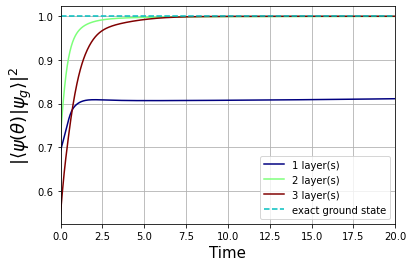

In [302]:
n = 3
colors = plt.cm.jet(np.linspace(0,1,n))

for kkk in range(3):
    plt.plot(time_domain,expt_value[kkk], color = colors[kkk],label = str(kkk+1)+" layer(s)")
plt.plot(time_domain,1.*np.ones(len(time_domain)), ls = "--", color ="c",label = "exact ground state")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,20)
#plt.ylim(0.99,1)

#plt.savefig("Imaginary_time_evolution_fidelity_over_layers_3qutrits_M=0.1.pdf")

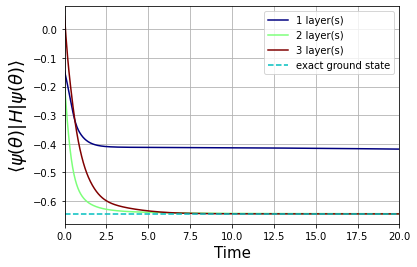

In [301]:
for kkk in range(3):
    plt.plot(time_domain,energyy[kkk], color = colors[kkk],label = str(kkk+1)+" layer(s)")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="c",label = "exact ground state")

plt.ylabel(r"$\langle \psi(\theta)|H|\psi(\theta)\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,20)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_over_layers_3qutrits_M=0.1.pdf")

In [114]:
N = 1
def var_ansatz(theta,psi_0):
    psi = psi_0
    for i in range(coeff*N):
        psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

    return psi
energy_1layer = []
for k in range(10):
    psi_var = var_ansatz(THETA_1[k],psi_0)

    for i in range(L+1):
        psi_var = (Proj[i]+Proj_0[i])@psi_var
        
    norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))
    energy_1layer.append(np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2))


In [115]:
N = 2
def var_ansatz(theta,psi_0):
    psi = psi_0
    for i in range(coeff*N):
        psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

    return psi
energy_2layer = []
for k in range(10):
    psi_var = var_ansatz(THETA_2[k],psi_0)

    for i in range(L+1):
        psi_var = (Proj[i]+Proj_0[i])@psi_var
        
    norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))
    energy_2layer.append(np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2))

In [116]:
N = 3
def var_ansatz(theta,psi_0):
    psi = psi_0
    for i in range(coeff*N):
        psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

    return psi
energy_3layer = []
for k in range(10):
    psi_var = var_ansatz(THETA_3[k],psi_0)

    for i in range(L+1):
        psi_var = (Proj[i]+Proj_0[i])@psi_var
        
    norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))
    energy_3layer.append(np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2))

(0.0, 10.0)

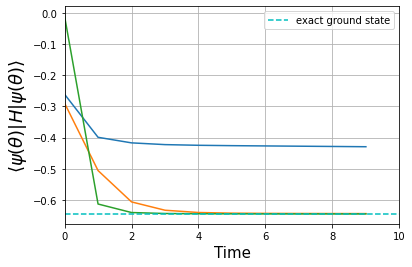

In [118]:
plt.plot(np.linspace(0,9,10),energy_1layer)
plt.plot(np.linspace(0,9,10),energy_2layer)
plt.plot(np.linspace(0,9,10),energy_3layer)

plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="c",label = "exact ground state")

plt.ylabel(r"$\langle \psi(\theta)|H|\psi(\theta)\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_over_layers_3qutrits_M=0.1.pdf")

In [131]:
f = open("Variational_parameters_and_energy_1layer_3Qutrits,M=0.1.txt", "a")
f.write("N"+" ")
for i in range(len(THETA_1[0])):
    f.write("Theta_"+str(i)+" ")
f.write("Energy\n")
for i in range(10):
    for l in range(len(THETA_1[0])):
        f.write(str(THETA_1[i][l])+" ")
    f.write(str(energy_1layer[i])+"\n")
f.close()

In [132]:
f = open("Variational_parameters_and_energy_2layer_3Qutrits,M=0.1.txt", "a")
f.write("N"+" ")
for i in range(len(THETA_2[0])):
    f.write("Theta_"+str(i)+" ")
f.write("Energy\n")
for i in range(10):
    for l in range(len(THETA_2[0])):
        f.write(str(THETA_2[i][l])+" ")
    f.write(str(energy_2layer[i])+"\n")
f.close()

In [133]:
f = open("Variational_parameters_and_energy_3layer_3Qutrits,M=0.1.txt", "a")
f.write("N"+" ")
for i in range(len(THETA_3[0])):
    f.write("Theta_"+str(i)+" ")
f.write("Energy\n")
for i in range(10):
    for l in range(len(THETA_3[0])):
        f.write(str(THETA_3[i][l])+" ")
    f.write(str(energy_3layer[i])+"\n")
f.close()

###### import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.xlim(5.9,6.1)
plt.show()

In [212]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [214]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [218]:
for i in range(coeff*N):
    print(Y[0][i])

0.37141536888406607
0.6602899660443315
0.11637371823579168
0.39901353290549235
0.9247979940631299
0.026453178512319396
0.4382807802429473
0.07025615093206115
0.3606296388374573
0.8138966259351307
0.9031720383192907
0.523454217057356
0.9272695715059814
0.9827474226150743
0.2639324508516817
0.41284186279042756
0.8757225556853009
0.523982524132141
0.9490899608210723
0.6202612047452045
0.19801202641088236
0.6716191124543176


(0.0, 10.0)

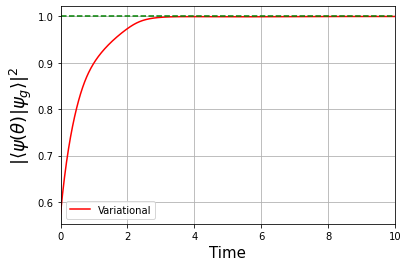

(0.0, 10.0)

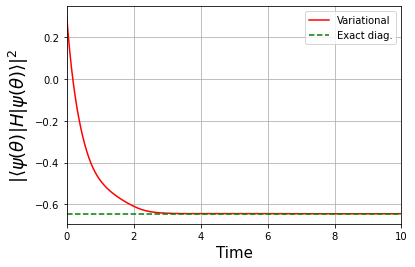

In [220]:
plt.plot(time_domain,energy, color = "red",label = "Variational")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="g", label = "Exact diag.")

plt.ylabel(r"$|\langle \psi(\theta)|H|\psi(\theta)\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_3qutrits_M=0.1_N=2_1.pdf")

In [221]:
print(expt_value_u[-1])

0.999481430342308


In [124]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

[1 1 2 4]
[1 1 2 3 4]
[1 1 2 3 4 5]


In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4


In [168]:
data_fidelity_1d = np.loadtxt("Imaginary_time_evolution_fidelity: 3Qutrits,M=0.1.txt")
data_energy_1d = np.loadtxt("Imaginary_time_evolution_energy: 3Qutrits,M=0.1.txt")

In [169]:
data_fidelity_2d = np.loadtxt("Imaginary_time_evolution_2d_fidelity: 1plaquette,M=0.1.txt")
data_energy_2d = np.loadtxt("Imaginary_time_evolution_2d_energy: 1plaquette,M=0.1.txt")


In [181]:
time_1d = []
for i in range(756):
    time_1d.append(data_fidelity_1d[i][0])
    


In [182]:
time_2d = []
for i in range(76):
    time_2d.append(data_fidelity_2d[i][0])
    


In [183]:
fidelity_1d = [[]for i in range(3)]
energy_1d = [[]for i in range(3)]

for i in range(756):
    fidelity_1d[0].append(data_fidelity_1d[i][1])
    fidelity_1d[1].append(data_fidelity_1d[i][2])
    fidelity_1d[2].append(data_fidelity_1d[i][3])
    energy_1d[0].append(data_energy_1d[i][1])
    energy_1d[1].append(data_energy_1d[i][2])
    energy_1d[2].append(data_energy_1d[i][3])  

print(np.shape(fidelity_1d[0]))
print(np.shape(time_1d))

(756,)
(756,)


In [184]:
fidelity_2d = [[]for i in range(3)]
energy_2d = [[]for i in range(3)]

for i in range(76):
    fidelity_2d[0].append(data_fidelity_2d[i][1])
    fidelity_2d[1].append(data_fidelity_2d[i][2])
    fidelity_2d[2].append(data_fidelity_2d[i][3])
    energy_2d[0].append(data_energy_2d[i][1])
    energy_2d[1].append(data_energy_2d[i][2])
    energy_2d[2].append(data_energy_2d[i][3])    

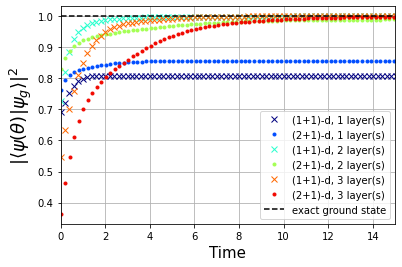

In [305]:
n = 3
colors = plt.cm.jet(np.linspace(0,0.8,n))
colors_2d = plt.cm.jet(np.linspace(0.2,0.9,n))

for kkk in range(3):
    plt.plot(time_1d[::10],fidelity_1d[kkk][::10],"x", color = colors[kkk],label ="(1+1)-d, "+str(kkk+1)+" layer(s)")
    plt.plot(time_2d,fidelity_2d[kkk],".", color = colors_2d[kkk],label ="(2+1)-d, "+str(kkk+1)+" layer(s)")

plt.plot(time_1d,1.*np.ones(len(time_1d)), ls = "--", color ="black",label = "exact ground state")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,15)
#plt.ylim(0.99,1)

plt.savefig("Poster_fidelity.pdf")

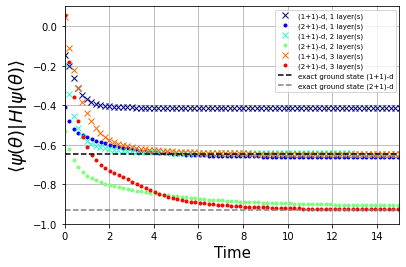

In [304]:
n = 3
colors = plt.cm.jet(np.linspace(0,0.8,n))
colors_2d = plt.cm.jet(np.linspace(0.1,0.9,n))

for kkk in range(3):
    plt.plot(time_1d[::10],energy_1d[kkk][::10],"x", color = colors[kkk],label ="(1+1)-d, "+str(kkk+1)+" layer(s)")
    plt.plot(time_2d,energy_2d[kkk],".", color = colors_2d[kkk],label ="(2+1)-d, "+str(kkk+1)+" layer(s)")

plt.plot(time_1d,eigenval[0]*np.ones(len(time_1d)), ls = "--", color ="black",label = "exact ground state (1+1)-d")
plt.plot(time_2d,-0.92917693*np.ones(len(time_2d)), ls = "--", color ="grey",label = "exact ground state (2+1)-d")

plt.ylabel(r"$\langle \psi(\theta)|H|\psi(\theta)\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend(loc = 1,prop={'size': 7})
plt.xlim(0,15)
plt.ylim(-1,0.1)

plt.savefig("Poster_energy.pdf")

In [288]:
a = np.logspace(np.log10(1),np.log10(76),76)

In [289]:
print(a)
for i in range(len(a)):
    a[i] = int((a[i]-1)*100)

[ 1.          1.0594428   1.12241905  1.18913878  1.25982452  1.33471202
  1.41405105  1.4981062   1.58715783  1.68150294  1.78145619  1.88735093
  1.99954036  2.11839864  2.24432219  2.37773099  2.51906998  2.66881056
  2.82745214  2.99552382  3.17358614  3.362233    3.56209355  3.77383437
  3.99816165  4.23582358  4.48761281  4.75436908  5.0369821   5.33639443
  5.65360467  5.98967077  6.34571358  6.72292058  7.12254981  7.54593413
  7.99448559  8.46970022  8.97316293  9.50655287 10.07164901 10.67033605
 11.30461072 11.97658845 12.68851042 13.44275103 14.24182582 15.08839985
 15.98529661 16.93550743 17.94220144 19.00873616 20.1386687  21.33576759
 22.60402539 23.94767199 25.37118871 26.87932325 28.47710553 30.16986447
 31.96324575 33.86323063 35.87615593 38.00873516 40.26808087 42.66172841
 45.19766108 47.88433669 50.73071582 53.7462917  56.94112187 60.32586169
 63.91179992 67.71089638 71.73582177 76.        ]


In [290]:
for i in range(len(a)):
    a[i] = int(a[i]/100)

In [291]:
print(a)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.
  1.  1.  2.  2.  2.  2.  2.  3.  3.  3.  4.  4.  4.  4.  5.  5.  6.  6.
  6.  7.  7.  8.  9.  9. 10. 10. 11. 12. 13. 14. 14. 15. 16. 18. 19. 20.
 21. 22. 24. 25. 27. 29. 30. 32. 34. 37. 39. 41. 44. 46. 49. 52. 55. 59.
 62. 66. 70. 75.]
